# Supproting containing lineage - Seurat analysis

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```


In [1]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)

luz_colors = c('#c466b0', '#779eed', '#aad3f2', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#7b9e99', '#91bd80', '#bdb380',  '#d4db81', '#ebd3c3',  '#dba781', 
               '#e08b8b', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

colors = c(luz_colors, 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))


downsample_data = function(anndataO, var = 'annotated_clusters', N=200){
    samples = list()
    for (cl in unique(anndataO@meta.data[,var]) ){
        cells = colnames(anndataO)[ anndataO@meta.data[,var] == cl ]
        samples[[cl]] = cells
        if( length(cells) > N )
            samples[[cl]] = sample(cells, size = N, replace = F)
    }
    anndataOF = subset(anndataO, cells = unlist(samples))
    
    gene_counts = tabulate(anndataOF@assays$RNA@counts@i + 1)
    anndataOF = subset(anndataOF, features = names(gene_counts)[ gene_counts > 3 ] )
    
    return(anndataOF)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: splines

Loading required package: foreach

Loaded gam 1.20


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [36]:
markers = list( 'somatic progenitor' = c('WT1', 'NR5A1'),
                'supporting lineage' = c('WNT6', 'WIPF3', 'GATA4'),
                'coelomic epi' = c('LRRN4', 'UPK3B', 'KLK11'),
                sLGR5 = c('LGR5', 'TSPAN8', 'CXCR4'),
                sPAX8 = c('PAX8', 'PLAU', 'CXCL12', 'CXCL14', 'SLIT1', 'SLIT2'),
                OSE= c('LHX9', 'LHX2', 'CALB2'),
                'pre-granulosa' = c( "KITLG", 'CSRNP1', 'CYP26B1', 'RSPO1', 'WNT4', 'FOXL2',  'OSR1', 'IRX3', 'CYP19A1',  'NOTCH3',  'HEYL', 'PROK1', 'RDH10', 'BMP2'),
                'WNT/beta-catenin' = c('AXIN2', 'WISP2', 'WIF1'),
                Sertoli = c('SOX9',  'AMH', 'INHBB', 'CITED1', 'CLDN11', 'WFDC2', 'CTNNA2'),
                'Fetal Leydig' = c('FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'CYP17A1'),
                mesenchymal = c('DCN', 'PDGFRA', 'COL1A1'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]

named character(0)

# Process with Seurat from raw

In [4]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [5]:
# # Remove CCG
# ccgs = read.csv('figures_manual_annotation/cell_cycle_genes.csv', stringsAsFactors = F)$X0
# anndata = subset(anndata, features = setdiff(allgenes, ccgs) )

In [6]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$seurat_clusters_v0 = meta$seurat_clusters[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$TP = meta$TP[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [7]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Supporting_female', 'Coel Epi', 'Sertoli')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
all(clusters_of_interest %in% anndata@meta.data$clusters)
table(anndata@meta.data$clusters)

An object of class Seurat 
28230 features across 104610 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

[1] TRUE


         Coel Epi           Sertoli Supporting_female 
            11578             37554             55478 

In [8]:
# Remove lowQC and doublets from previous round
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/supporting_annotation_doublets.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_previous = 'new'
anndata@meta.data$clusters_previous[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

table(anndata@meta.data$clusters_previous)


        coelEpi coelEpi_cycling         cycling       doublet_I      doublet_II 
           4188             987            4632            1012             647 
    FetalLeydig         lowQC_I        lowQC_II       lowQC_III        lowQC_IV 
            384            3822             957             960             112 
        Oi-like     ovarianSurf    preGC_I_OSR1  preGC_II_KITLG  preGC_III_GJA1 
           4181            4715           10630           14051           13466 
        Sertoli Sertoli_cycling     Sertoli_low   Sertoli_WFDC2          sKITLG 
          18911            4067            9223            1021             870 
          sLGR5           sPAX8 
           2429            3345 

In [9]:
# subset datasets to contain clusters of interest and remove doublets
# subset datasets to contain clusters of interest and remove doublets
clusters2remove = c(grep('doublet', anndata@meta.data$clusters_previous, value = T),
                    grep('Oi-like', anndata@meta.data$clusters_previous, value = T),
                    grep('cycling', anndata@meta.data$clusters_previous, value = T),
                    grep('new', anndata@meta.data$clusters_previous, value = T),
                    grep('lowQC', anndata@meta.data$clusters_previous, value = T))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, ! clusters_previous %in% clusters2remove)))
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, is_doublet == 'False' )))
anndata
table(anndata@meta.data$clusters_previous)

An object of class Seurat 
28230 features across 83233 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)


       coelEpi    FetalLeydig    ovarianSurf   preGC_I_OSR1 preGC_II_KITLG 
          4188            384           4715          10630          14051 
preGC_III_GJA1        Sertoli    Sertoli_low  Sertoli_WFDC2         sKITLG 
         13466          18911           9223           1021            870 
         sLGR5          sPAX8 
          2429           3345 

In [10]:
# anndata = downsample_data(anndata, 'clusters_previous', N = 1000)

In [11]:
# basic gene/cell filtering
message('Removing ', sum(anndata@meta.data$nCount_RNA < 500), ' cells with less than 500 nCount_RNA' )
anndata <- subset(anndata, cells = colnames(anndata)[ anndata@meta.data$nCount_RNA >= 500 ] )
                    
gene_counts = tabulate(anndata@assays$RNA@counts@i+1)
message('Removing ', sum(gene_counts <= 3), ' genes expressed in 3 or less cells' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )

Removing 0 cells with less than 500 nCount_RNA

Removing 4111 genes expressed in 3 or less cells



In [12]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
28230 features across 83233 samples within 1 assay 
Active assay: RNA (28230 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  RAD51, E2F8, RRM2, HJURP, EXO1, NEK2, CENPA, TPX2, NUF2, NDC80 
	   CDC25C, KIF2C, AURKB, KIF23, TTK, BLM, CCNE2, CKAP2L, BUB1, GTSE1 
	   CDCA2, KIF11, ANLN, CDCA3, DLGAP5, CDCA8, ECT2, BRIP1, GAS2L3, DSCC1 
Negative:  NASP, TMPO, UNG, GINS2, CDCA7, MCM2, MCM5, HMGB2, MCM6, TYMS 
	   CENPF, SLBP, CKAP5, MSH2, MCM4, CTCF, HELLS, RRM1, TOP2A, USP1 
	   ANP32E, SMC4, RFC2, UHRF1, CBX5, NUSAP1,

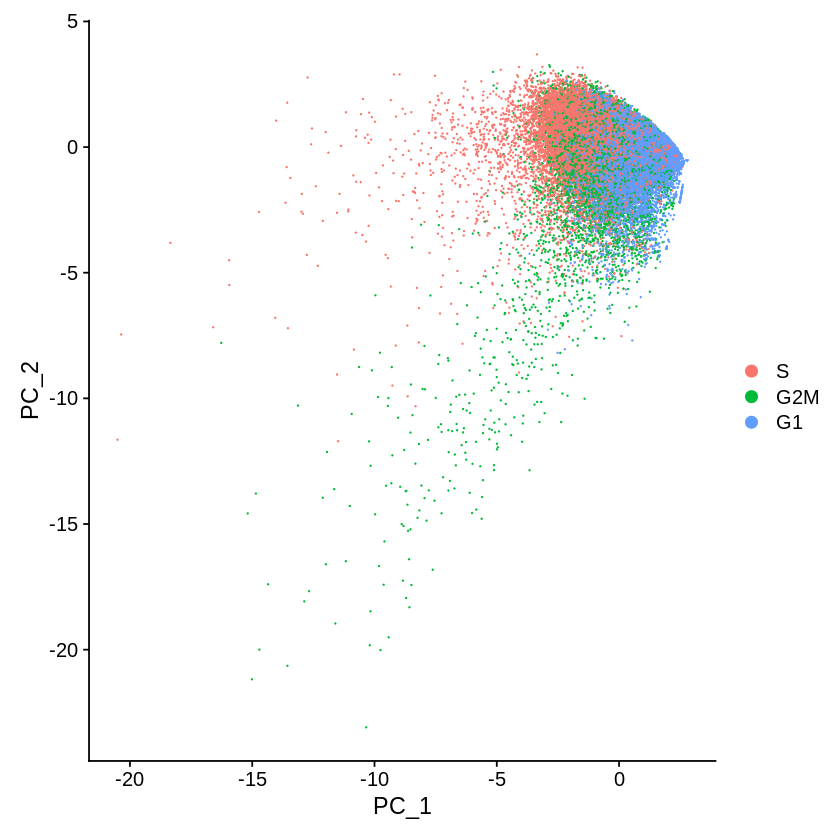

In [13]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [14]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  APOA1, AMH, CITED1, SERPINA5, GSTA1, INHA, SERPINF1, CD99, RPS4Y1, LGALS1 
	   FATE1, CLU, SOX9, INHBB, G6PD, CST3, HERC5, S100A10, BRICD5, GNG7 
	   MIR202HG, TRIM55, TAGLN2, TNNI3, PRNP, FHOD3, ZFAND5, CTSV, COL1A2, VCAN 
Negative:  LY6E, SPRR2F, BST2, NPY, CAV1, MEST, KRT18, KRT8, CRYM, ZFP36L1 
	   EMX2, COL3A1, IGFBP2, HLA-B, AHNAK, MDK, HLA-A, CAV2, NPM1, HLA-C 
	   HOPX, LDHA, FAM210B, COL11A1, LHX9, NSG1, NR2F2, B2M, CRNDE, WNT2B 
PC_ 2 
Positive:  MT3, CRYM, GATM, TOX3, KITLG, C15orf48, FAM210B, PRR15, CNTNAP4, MT2A 
	   NR1H4, PNCK, VAT1L, DSEL, KCTD12, IRX3, FOXL2, TM7SF2, GREB1, AP1S2 
	   GJA1, PDK1, ISYNA1, SERPINB9, CRNDE, CMIP, DACH1, UNC5B, EPN3, NXPH4 
Negative:  KLK11, UPK3B, GPC3, COL1A1, TNNT1, TPM2, MSLN, ANXA2, POSTN, SBSPON 
	   MGP, TM4SF1, MFAP2, EPS8L1, SULT1E1, KRT19, RARRES1, TMEM151A, LRRN4, PODXL 
	   NPW, COL9A3, PCOLCE, MMP23B, RERG, RAMP2, TFPI2, ELN, ETS2, SPARC 
PC_ 3 
Positive:  CYSTM1, UPK3B, MT2A, LHX9, COL11A1, ANXA5, LHX2, GABR

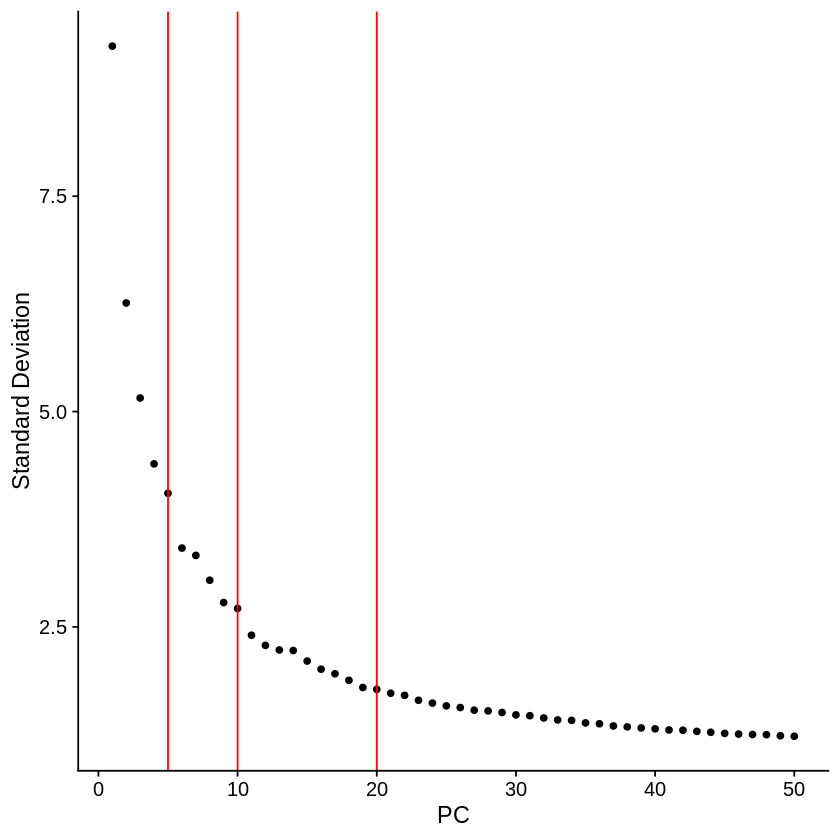

In [15]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [16]:
npca = 18
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0, lambda = 10, max.iter.harmony = 30, max.iter.cluster = 30)#, max.iter.harmony = 30, reference_values = c('Hrv3', 'Hrv58')) # sigma=0.2,

Harmony 1/30

Harmony 2/30

Harmony 3/30

Harmony 4/30

Harmony 5/30

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [17]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [18]:
anndata <- FindClusters(anndata, resolution = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 83233
Number of edges: 2498852

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8720
Number of communities: 20
Elapsed time: 40 seconds


In [19]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



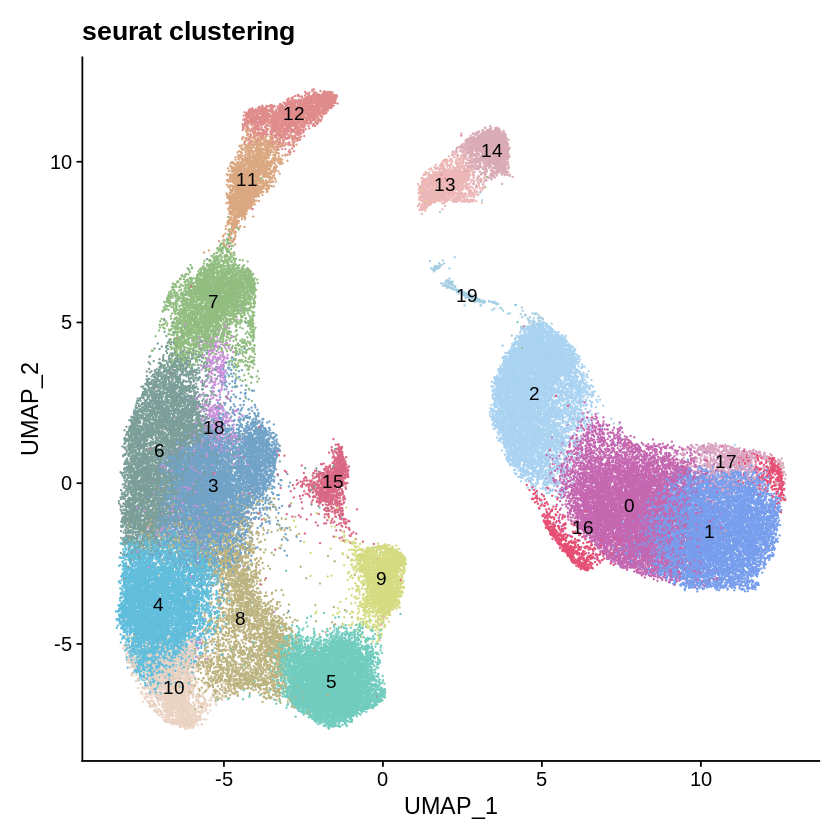

In [20]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-supporting/cleanNocycling_umap_clustering.pdf'), dpi = 75)

In [21]:
meta_sup = read.csv('figures-supporting/annotated.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_old = 'new'
anndata@meta.data$clusters_old[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

Saving 13.3 x 13.3 in image



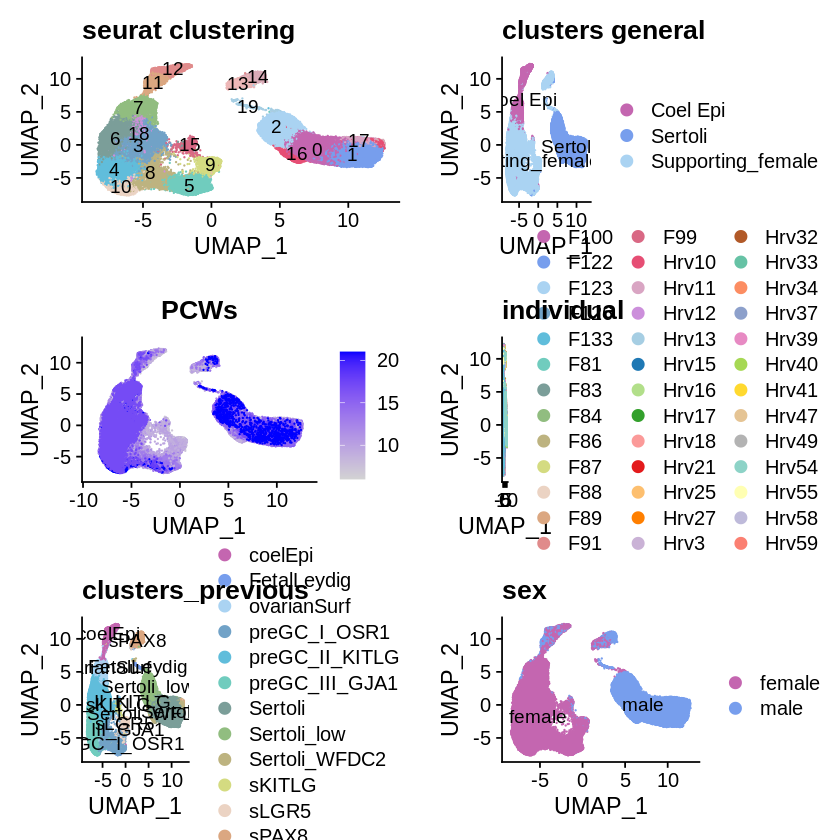

In [22]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'clusters_old', label = T, cols = colors) + ggtitle('clusters_old')
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters', label = T, cols = colors) + ggtitle('clusters general')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'clusters_previous',  label = T, cols = colors) + ggtitle('clusters_previous')
p6 = DimPlot(anndata, reduction = "umap", group.by = 'sex',  label = T, cols = colors) + ggtitle('sex')
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 2)
ggsave(filename = paste0('figures-supporting/cleanNocycling_umap_metadata.pdf'), scale = 2, dpi = 75)

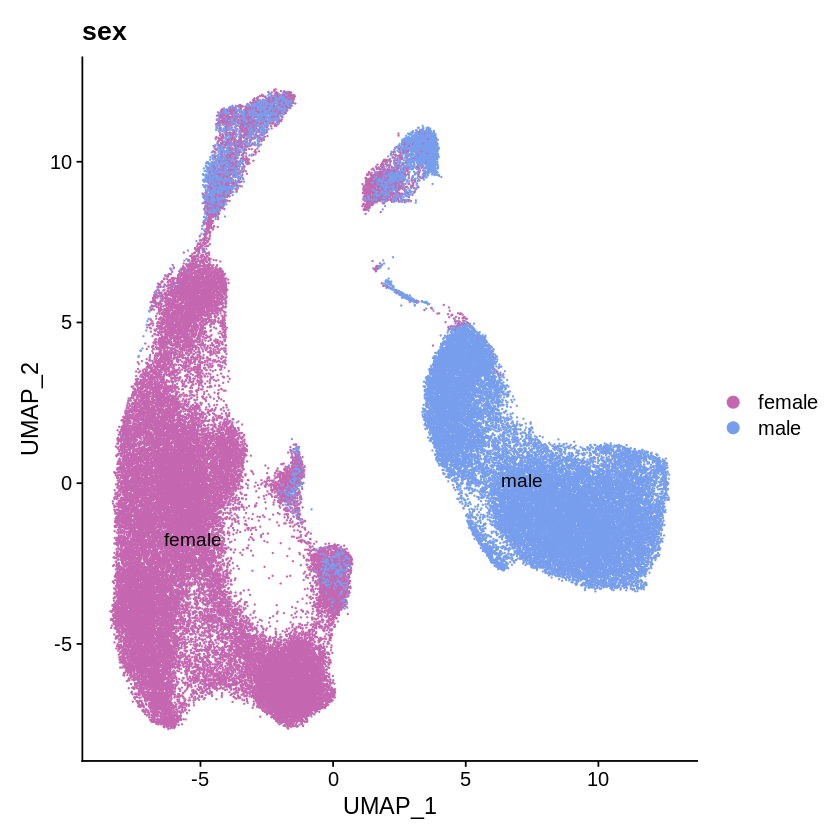

In [23]:
p6

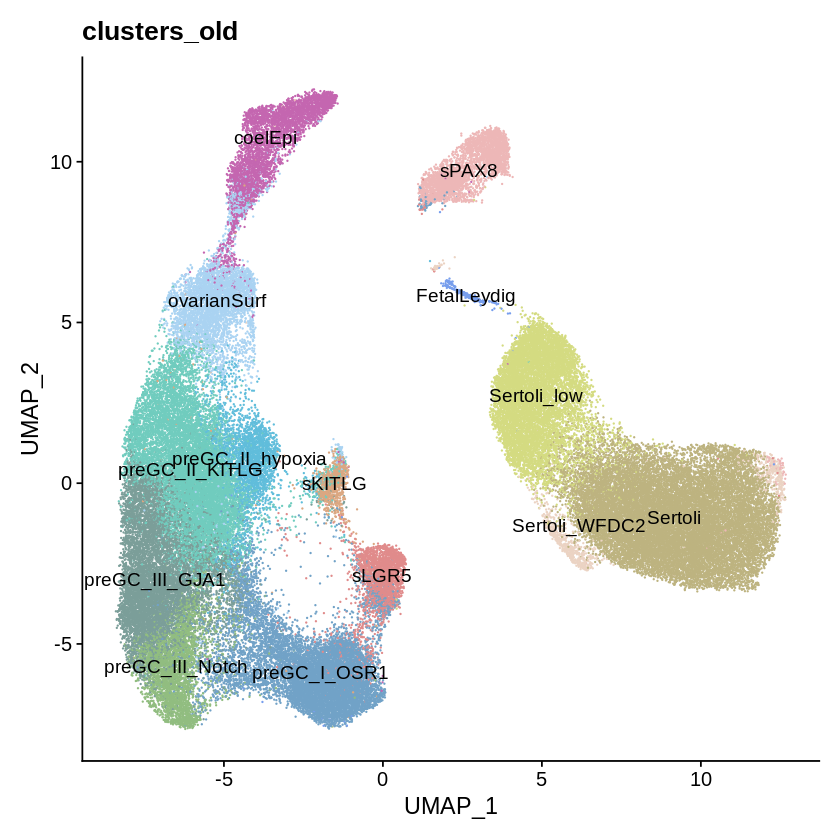

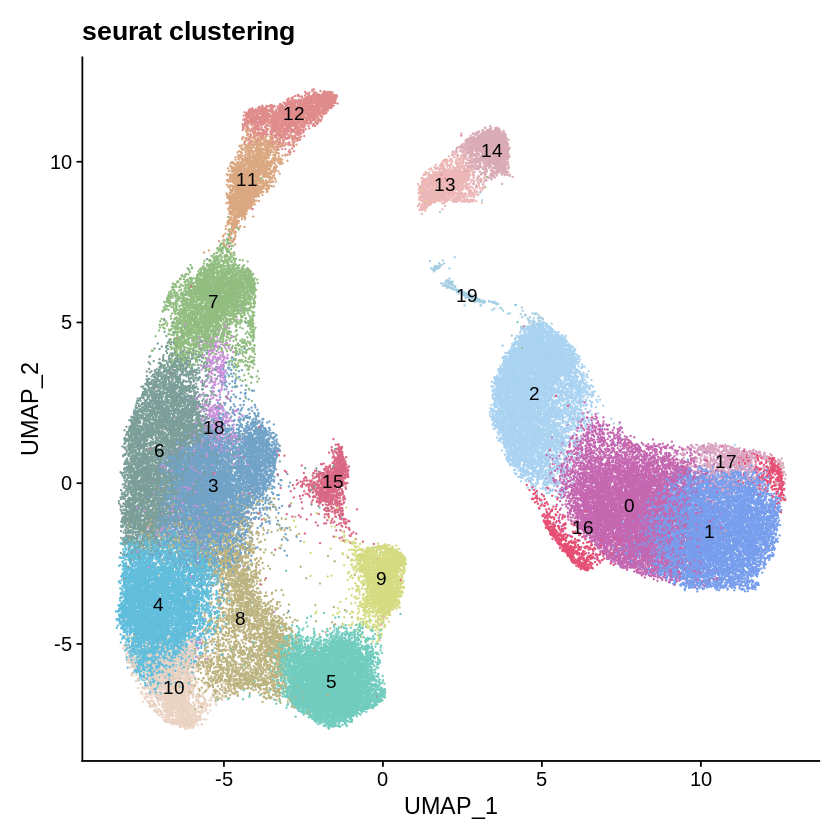

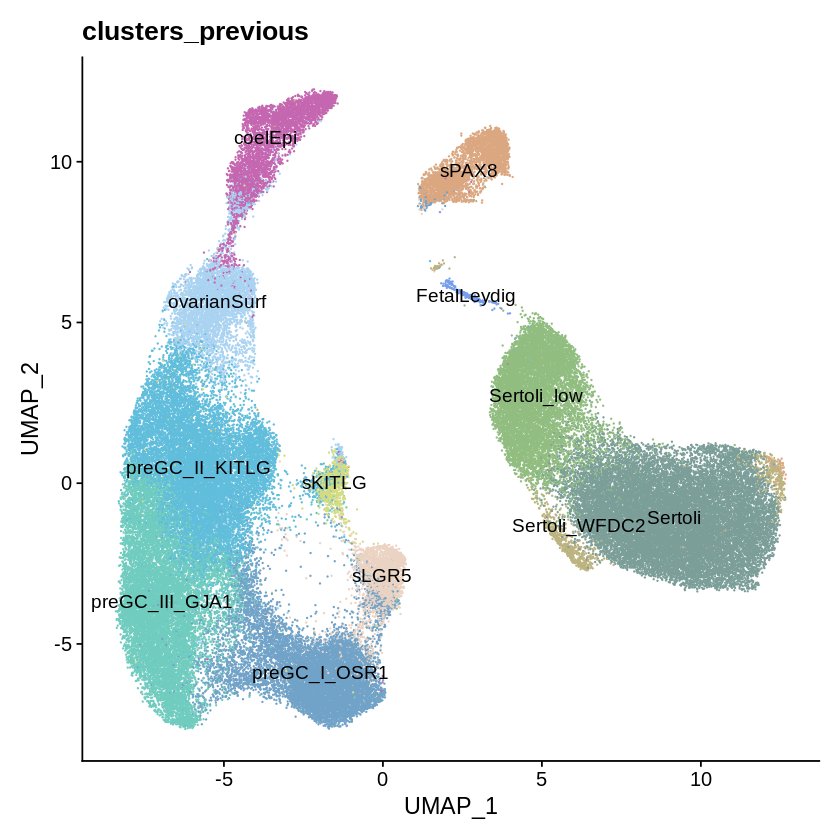

In [24]:
p1b + NoLegend()
p1
p5 + NoLegend()

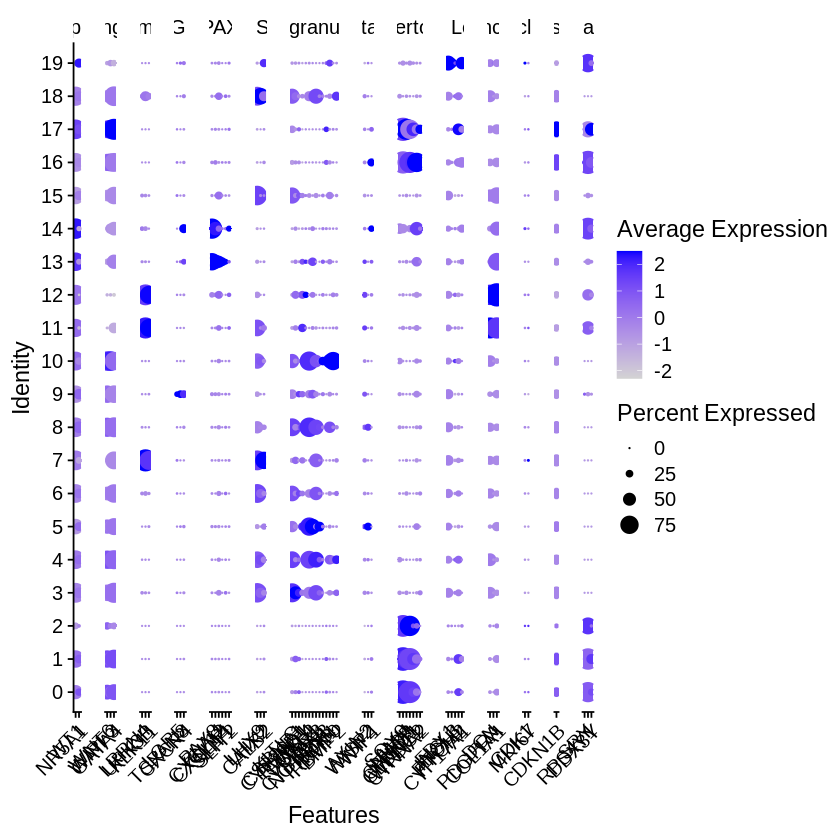

In [42]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_markers.pdf'), dpi = 75, height = 7, width = 30)

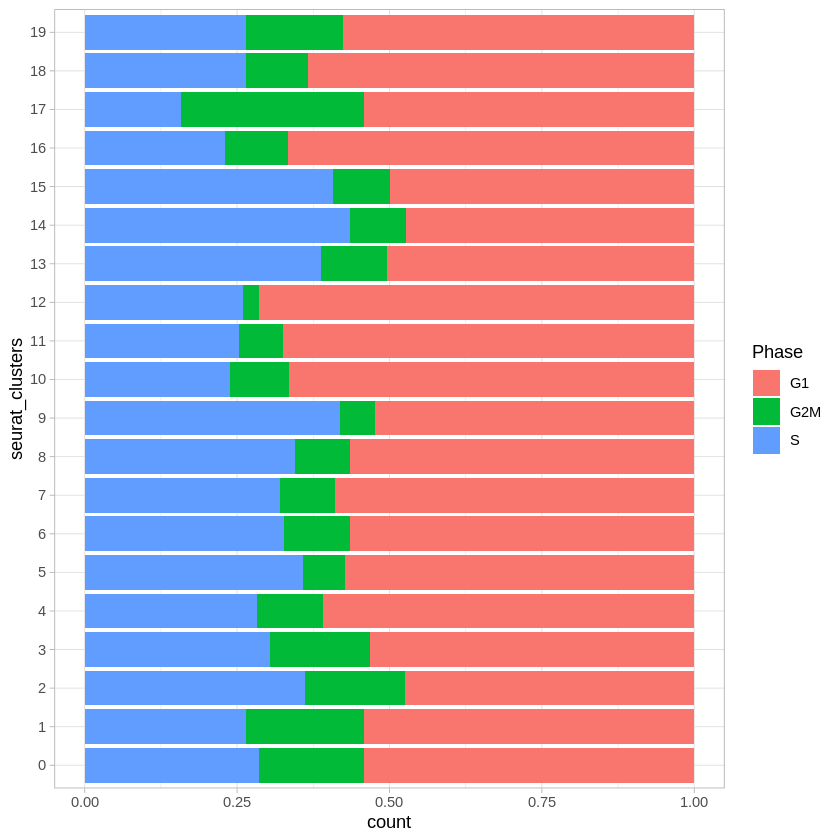

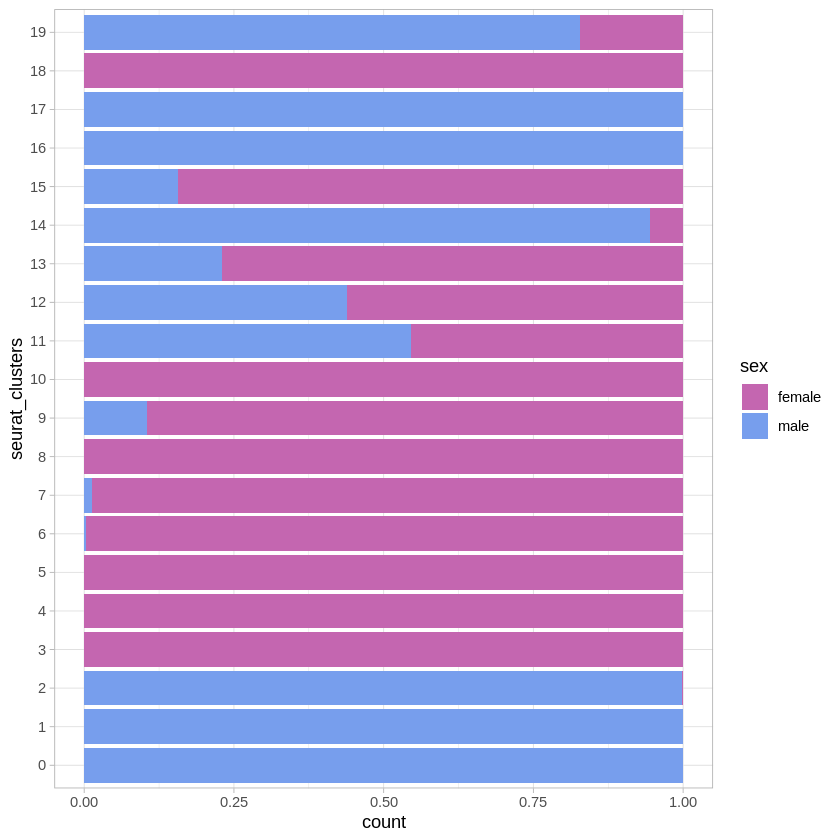

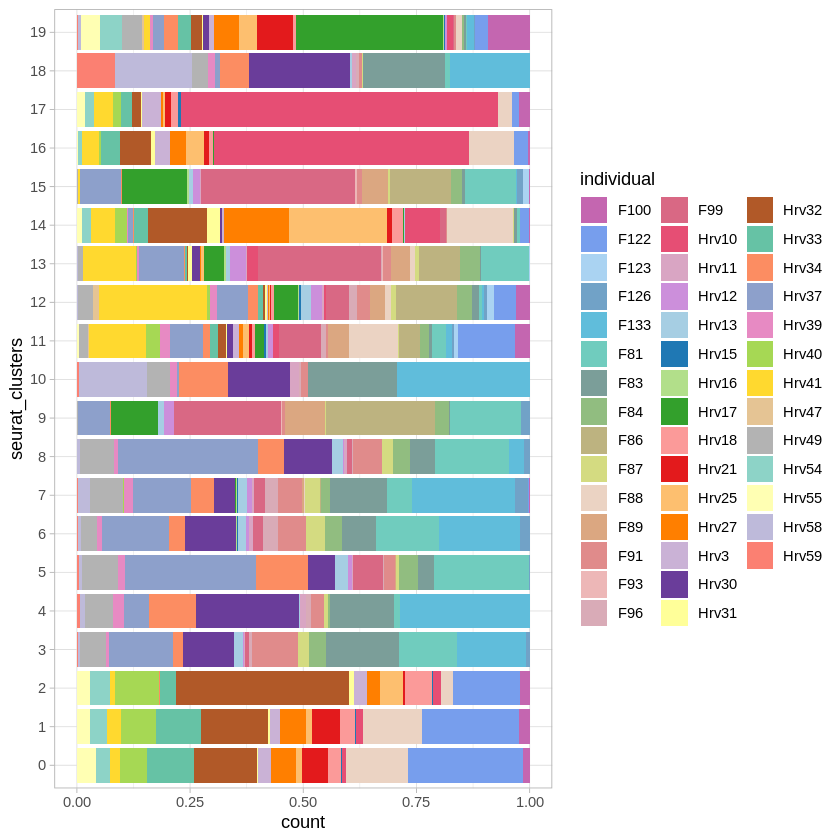

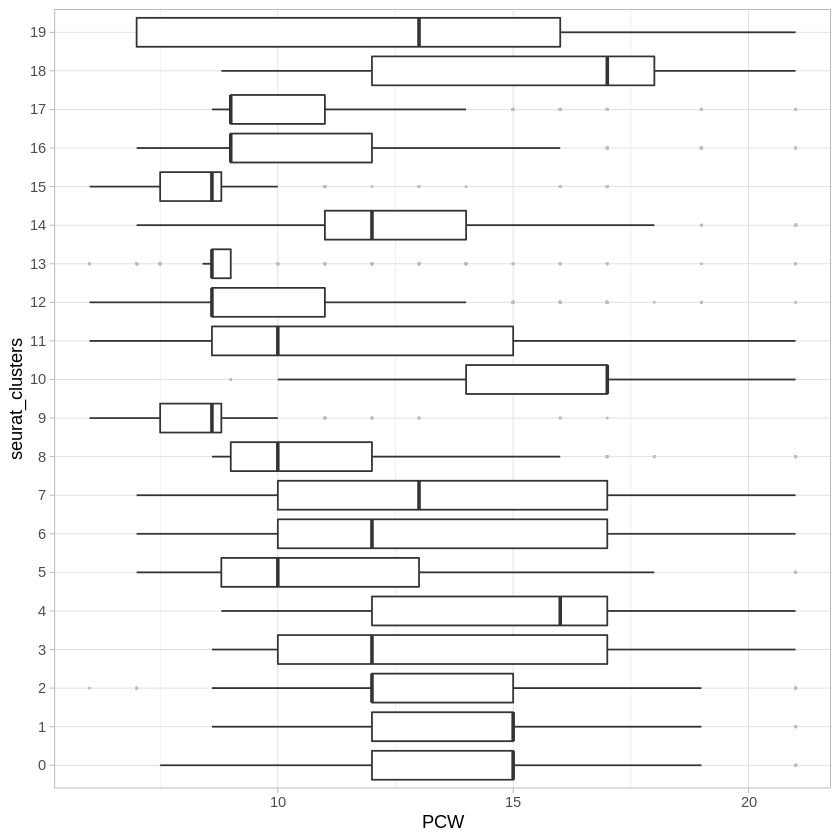

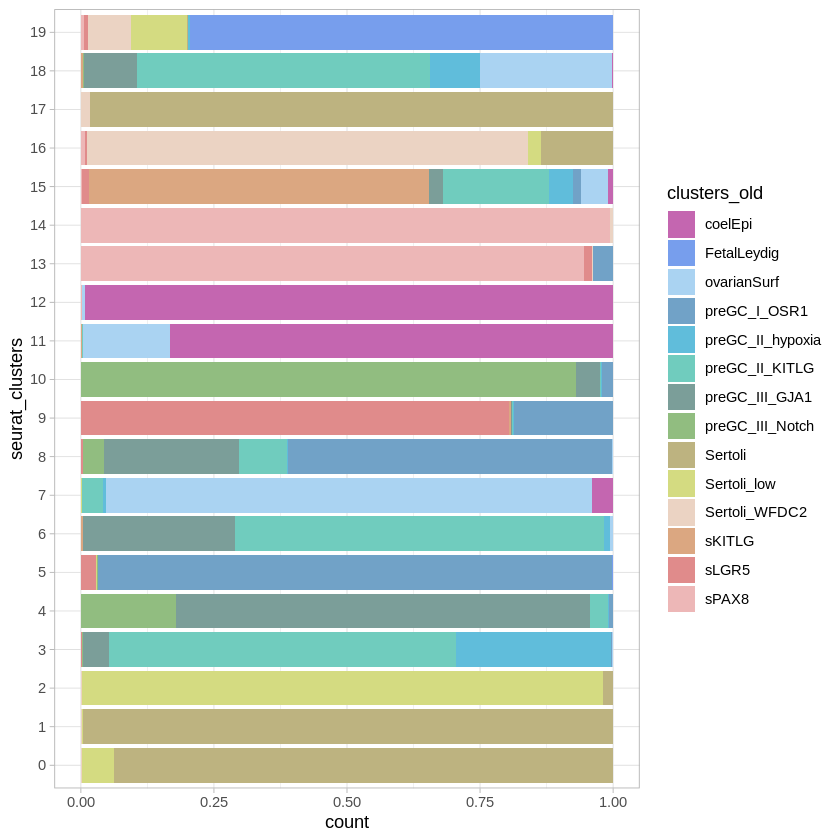

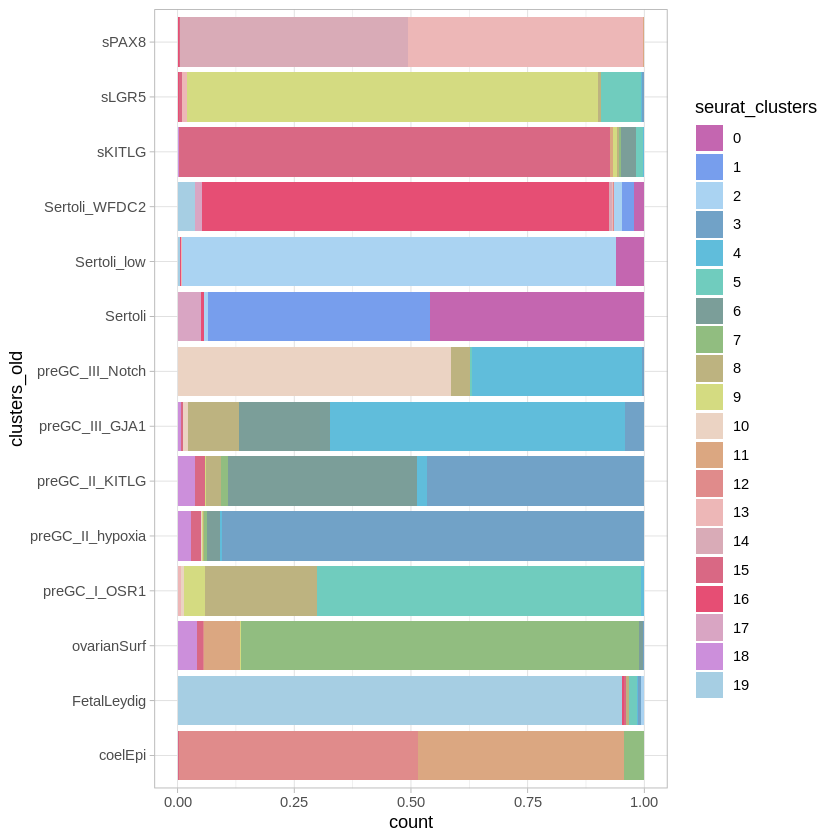

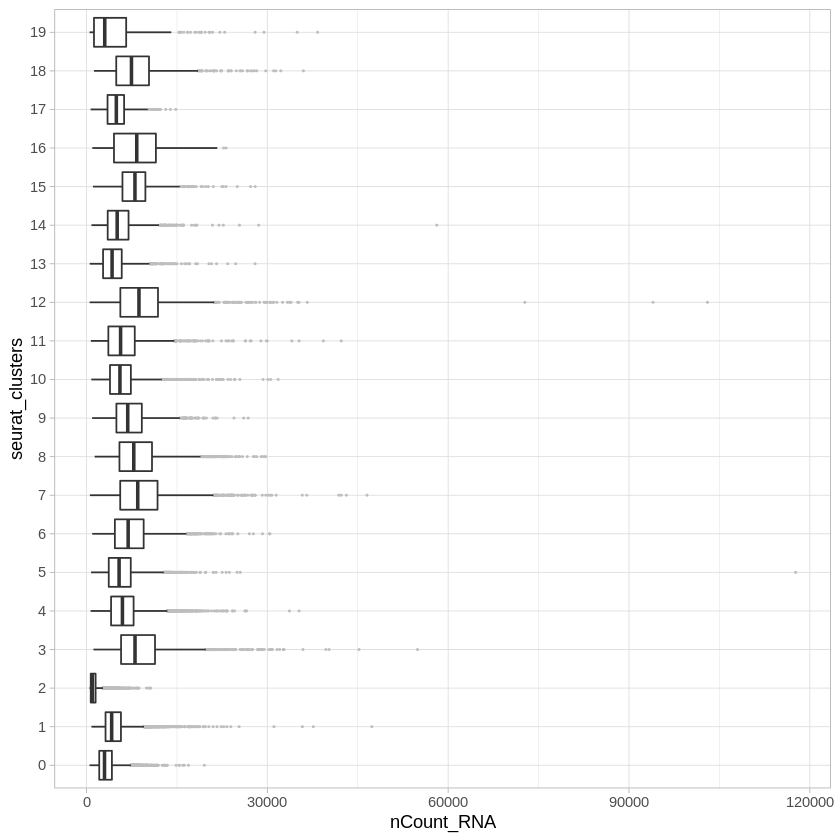

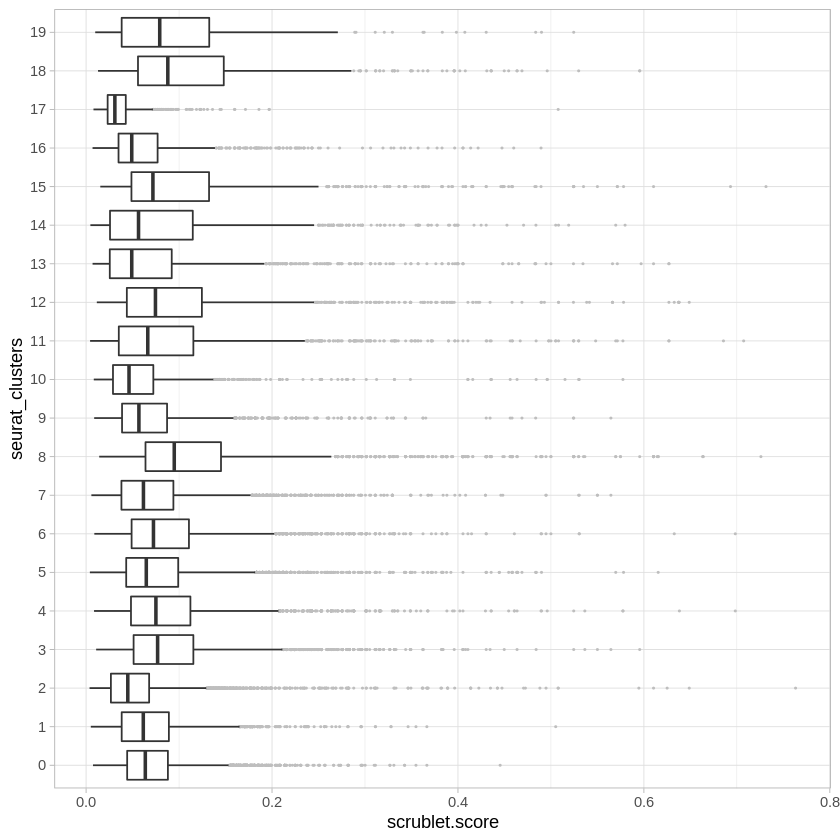

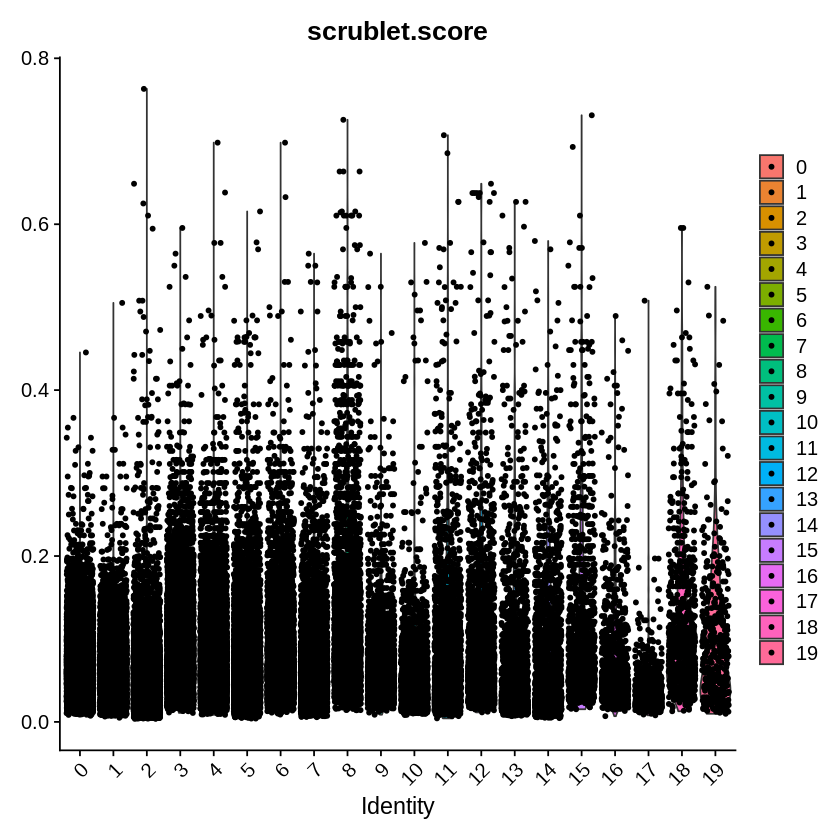

In [26]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()



ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()


ggplot(anndata@meta.data, aes(x = seurat_clusters , fill = clusters_old )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x =  clusters_old, fill = seurat_clusters  )) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

ggplot(anndataO@meta.data, aes(x = seurat_clusters, y = nCount_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
ggplot(anndata@meta.data, aes(x = seurat_clusters, y = scrublet.score)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()

VlnPlot(anndata, 'scrublet.score')

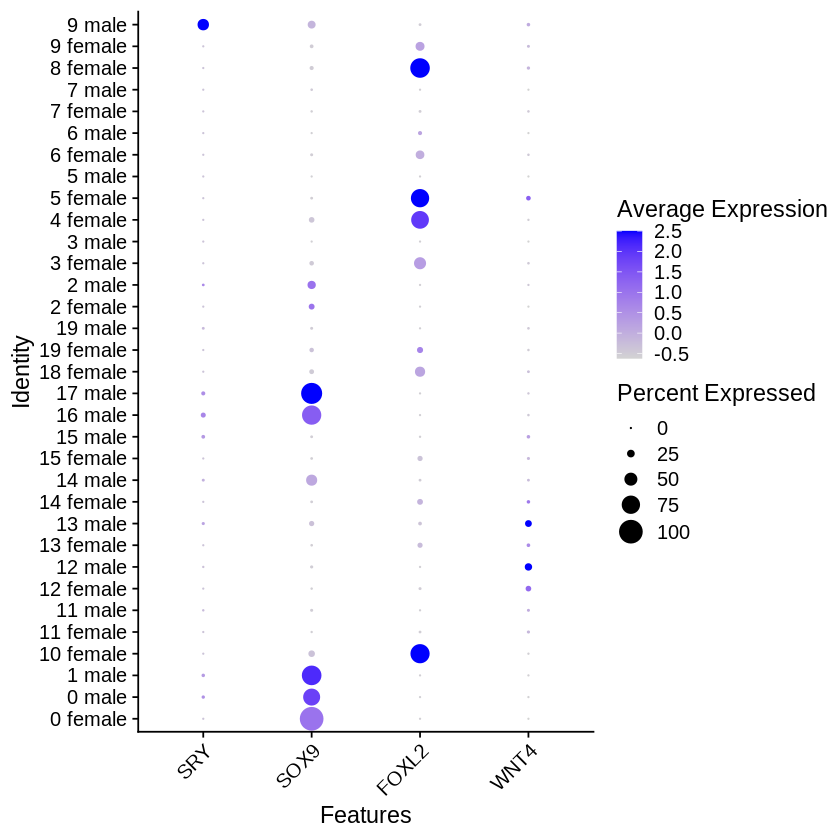

In [27]:
anndataO$cl_per_sex = paste(anndataO$seurat_clusters, anndataO$sex) 
DotPlot(anndataO, features = c('SRY', 'SOX9', 'FOXL2', 'WNT4'), group.by = 'cl_per_sex') + RotatedAxis()

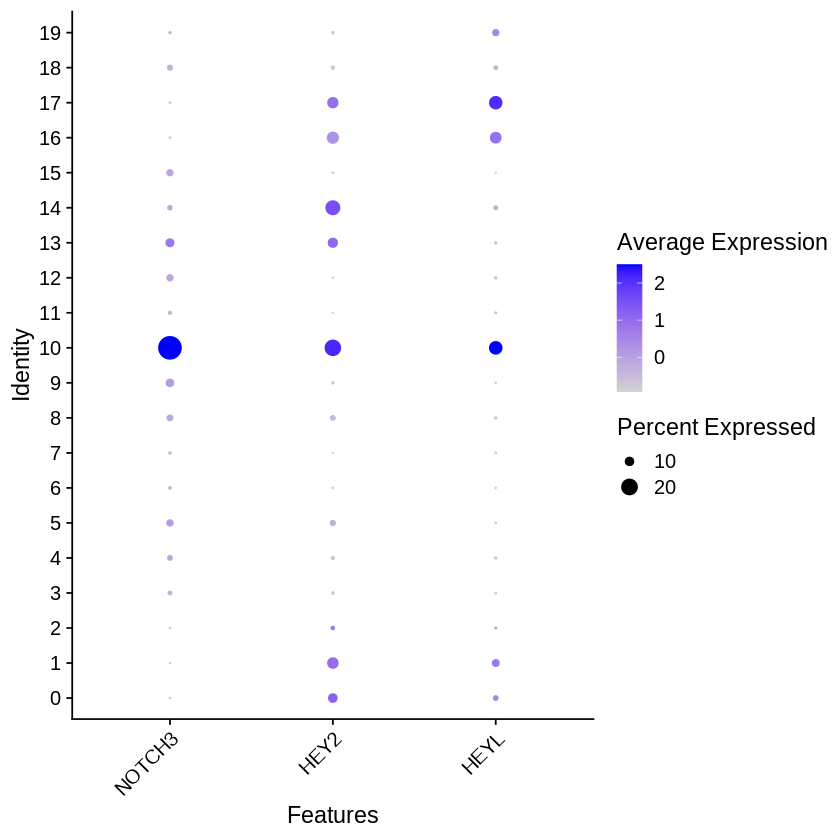

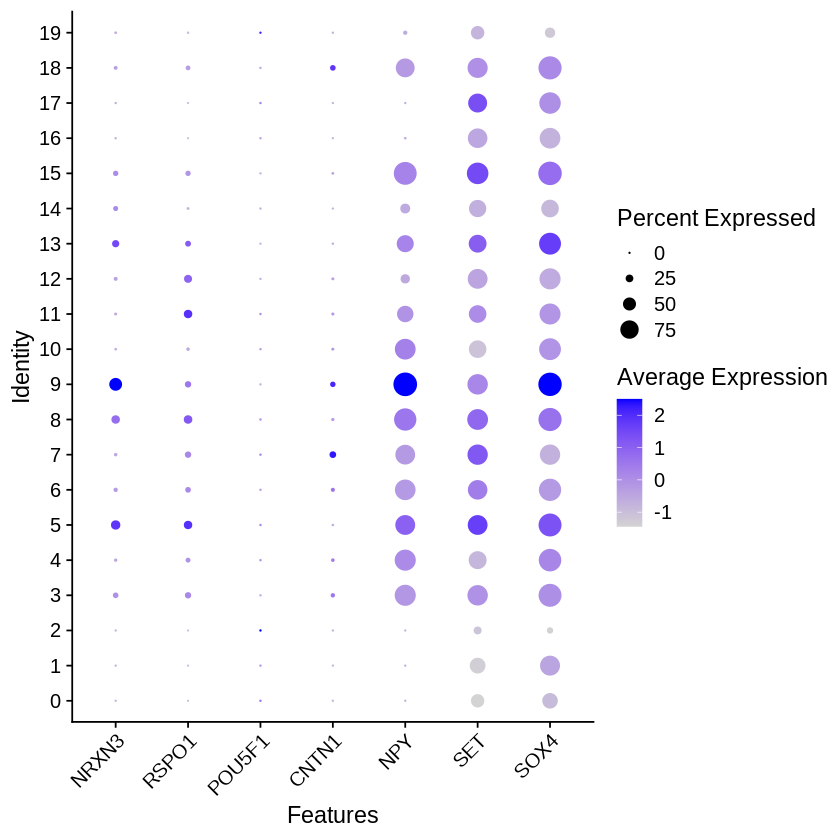

In [28]:
DotPlot(anndataO, features = c('NOTCH3', 'HEY2', 'HEYL'), group.by = 'seurat_clusters') + RotatedAxis()
DotPlot(anndataO, features = c('NRXN3', 'RSPO1', 'POU5F1', 'CNTN1', 'NPY', 'SET', 'SOX4'), group.by = 'seurat_clusters') + RotatedAxis()

### DEGs and GSA

In [29]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 20)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-supporting/cleanNocycling_cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 400  10

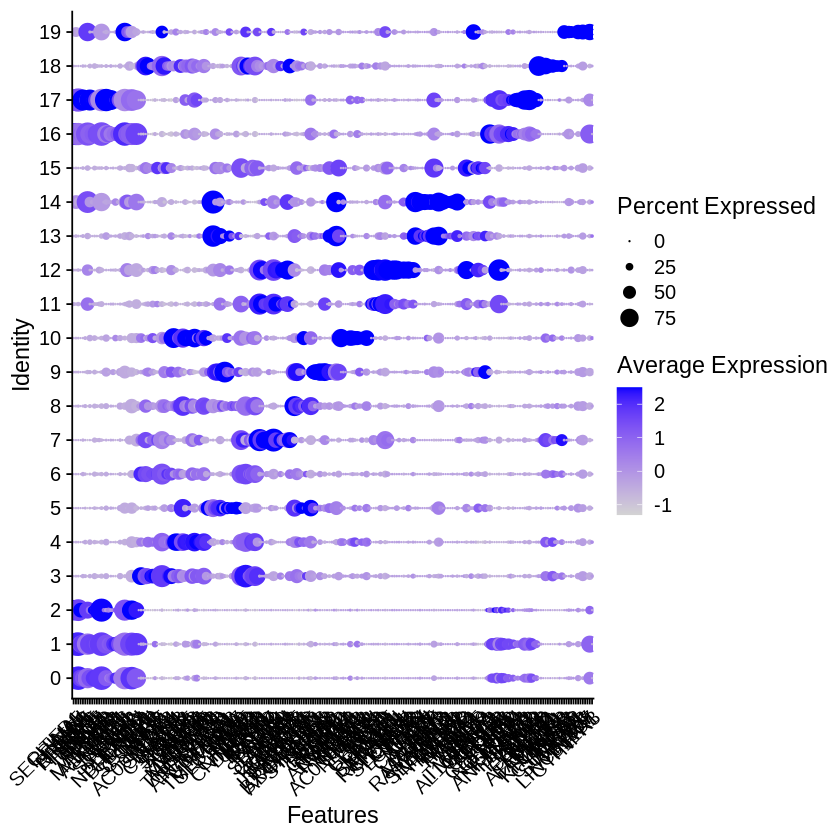

In [30]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 5, width = 45)

# Annotate clusters

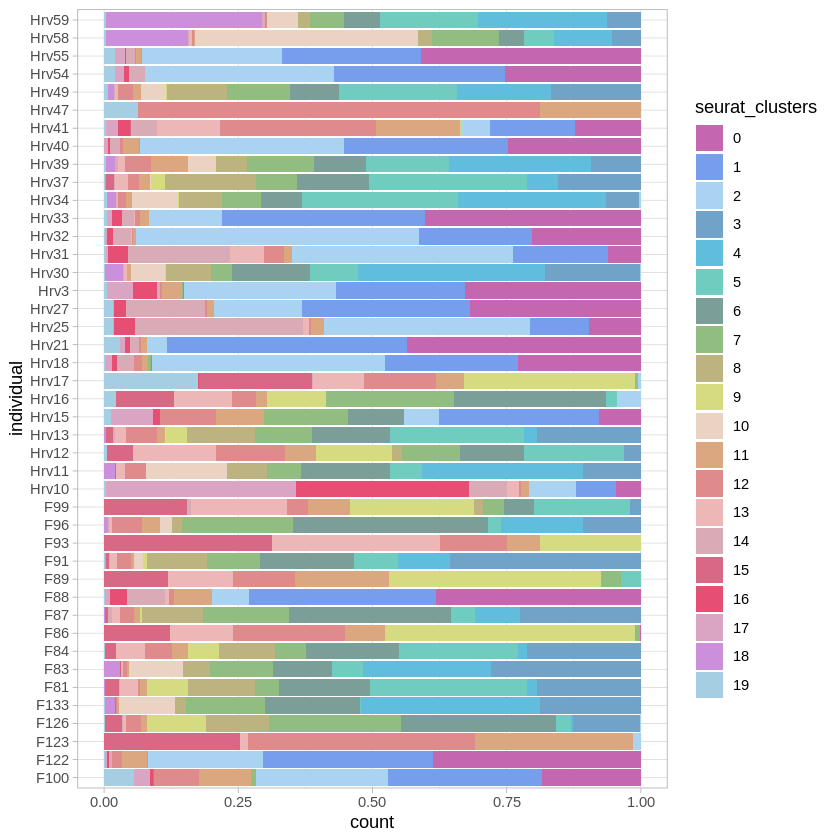

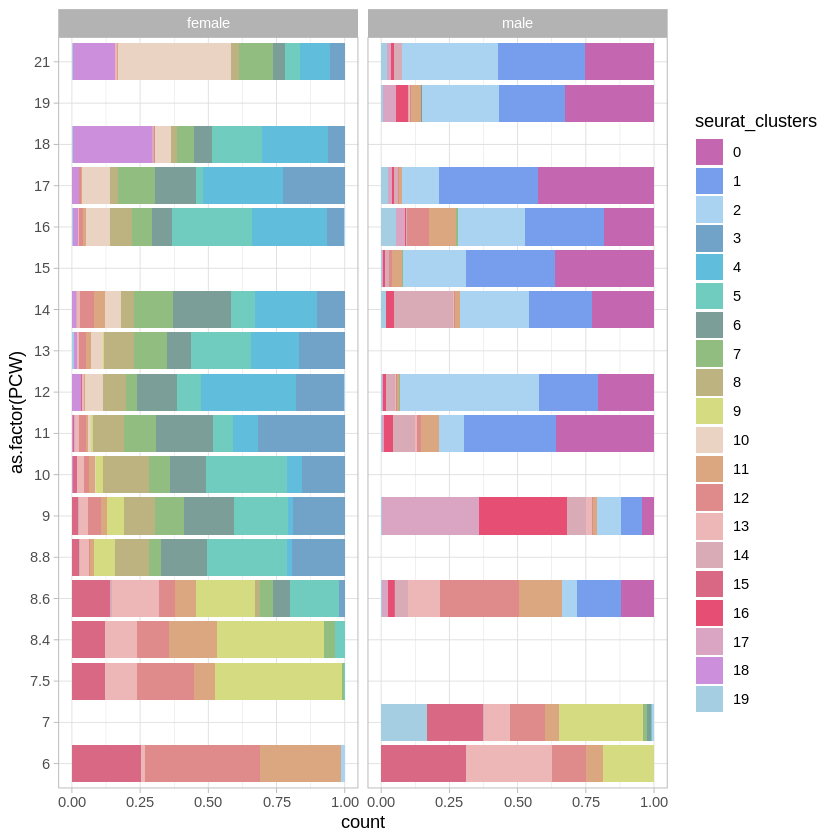

In [31]:
ggplot(anndata@meta.data, aes(x = individual , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = seurat_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

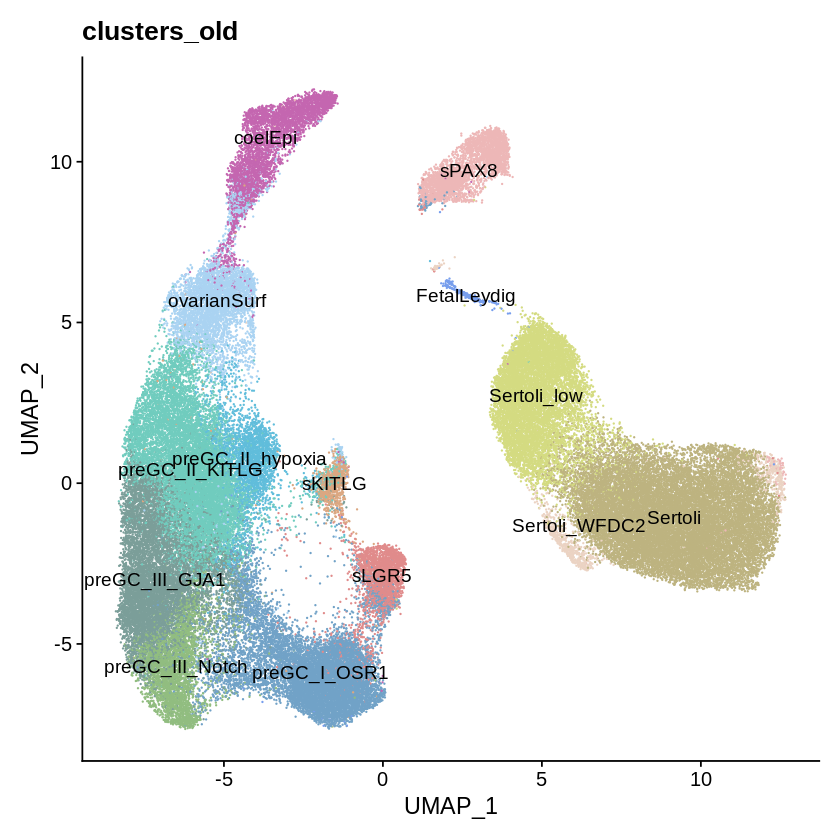

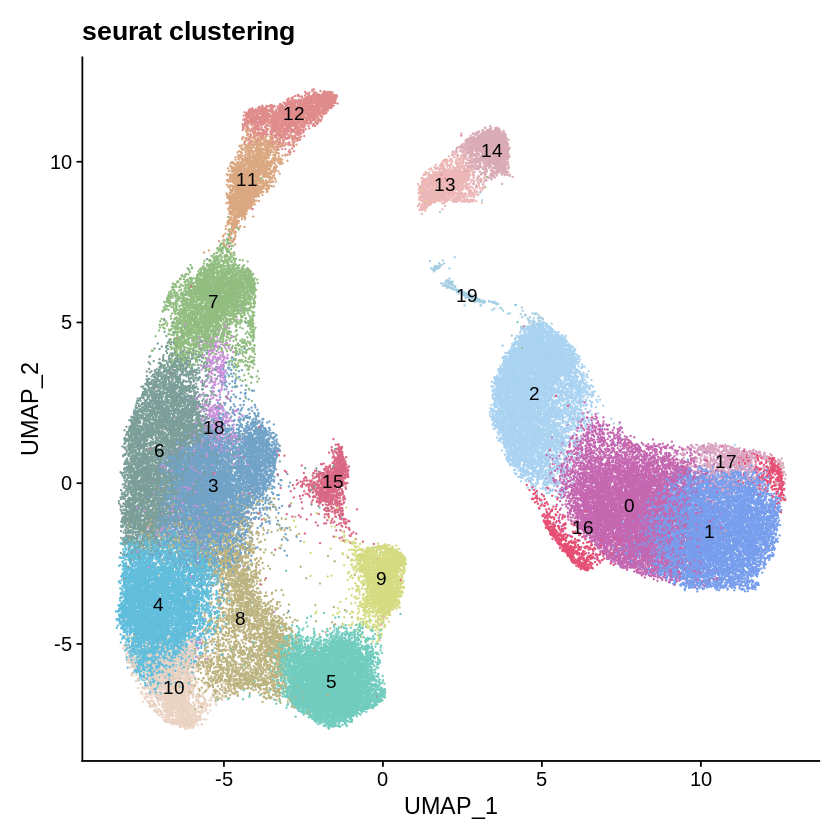

In [34]:
p1b + NoLegend()
p1

In [39]:
cluster_names = c('Sertoli',#0
                 'Sertoli',
                 'Sertoli_low',
                 'preGC_II_hypoxia',
                 'preGC_III',
                 'preGC_I_OSR1',#5
                 'preGC_II',
                 'ovarianSurf',
                 'preGC_I_OSR1',
                 'sLGR5',
                 'preGC_III_Notch',#10
                 'coelEpi',
                 'coelEpi',
                 'sPAX8b',
                 'sPAX8m',
                  'sKITLG',#15
                  'Sertoli_WFDC2',
                  'Sertoli',
                  'ovarianSurf',
                 'FetalLeydig-like'
)



anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]


anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = unique(sort(cluster_names)))



anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = )


Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

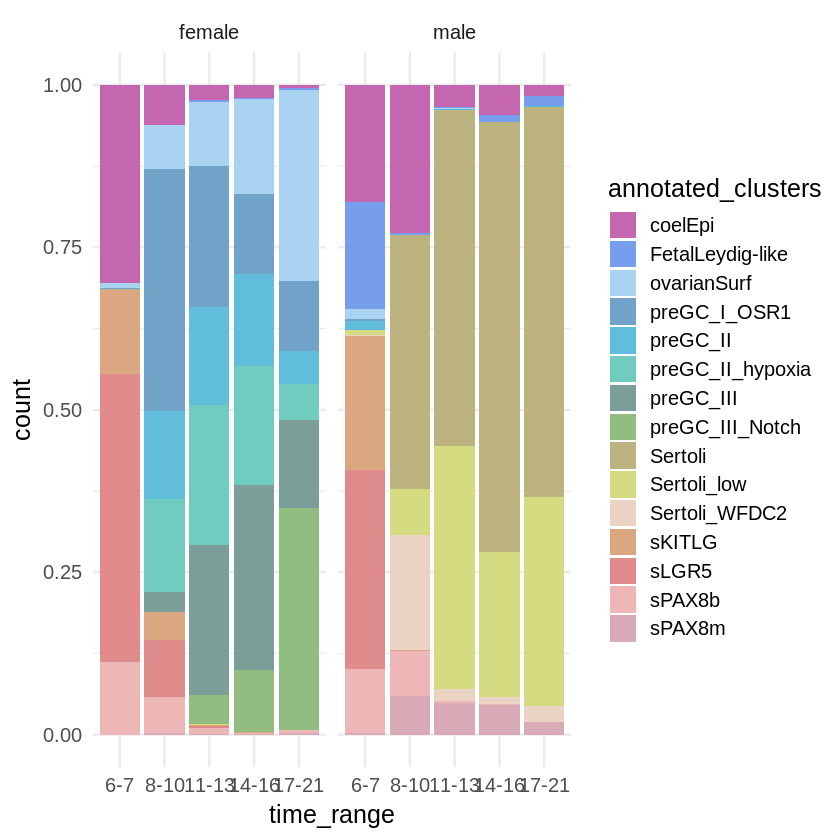

In [40]:
anndataO@meta.data$time_range = '6-7'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 8 ] = '8-10'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 11 ] = '11-13'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >= 14 ] = '14-16'
anndataO@meta.data$time_range[ anndataO@meta.data$PCW >17 ] = '17-21'
anndataO@meta.data$time_range = factor(anndataO@meta.data$time_range, levels = c('6-7', '8-10', '11-13', '14-16', '17-21') )
ggplot(anndataO@meta.data, aes(x=time_range, fill = annotated_clusters) ) + 
    scale_fill_manual(values = luz_colors) +
    facet_wrap(~sex)+
    geom_bar(position = 'fill')+
#     geom_bar()+
    theme_minimal(15)

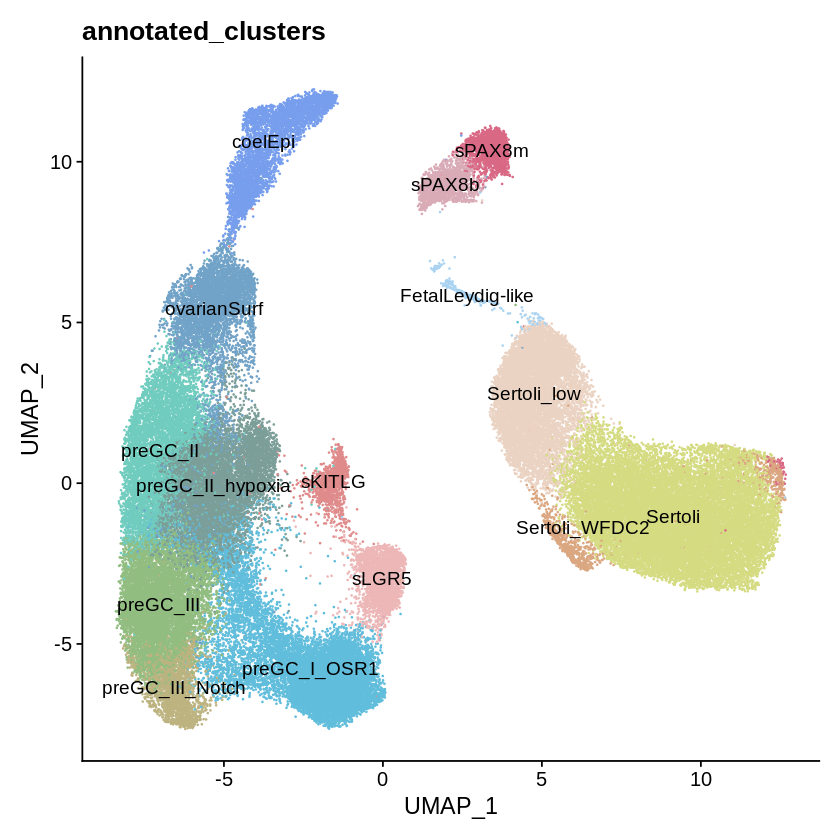

In [43]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()
ggsave(filename = paste0('figures-supporting/cleanNocycling_umap_annotated.pdf'), dpi = 75, width = 7, height = 7)

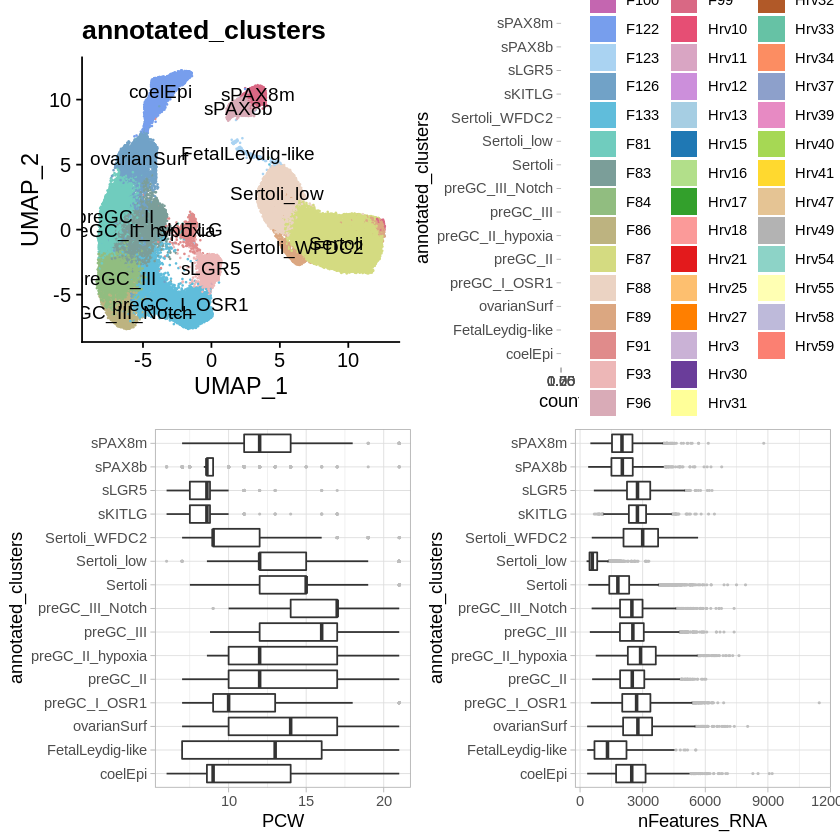

In [44]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, y = nFeatures_RNA)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1b+NoLegend(), b1, b2, b3, ncol = 2)
ggsave(filename = paste0('figures-supporting/cleanNocycling_metadata_annotated.pdf'), dpi = 75, width = 10, height = 10)

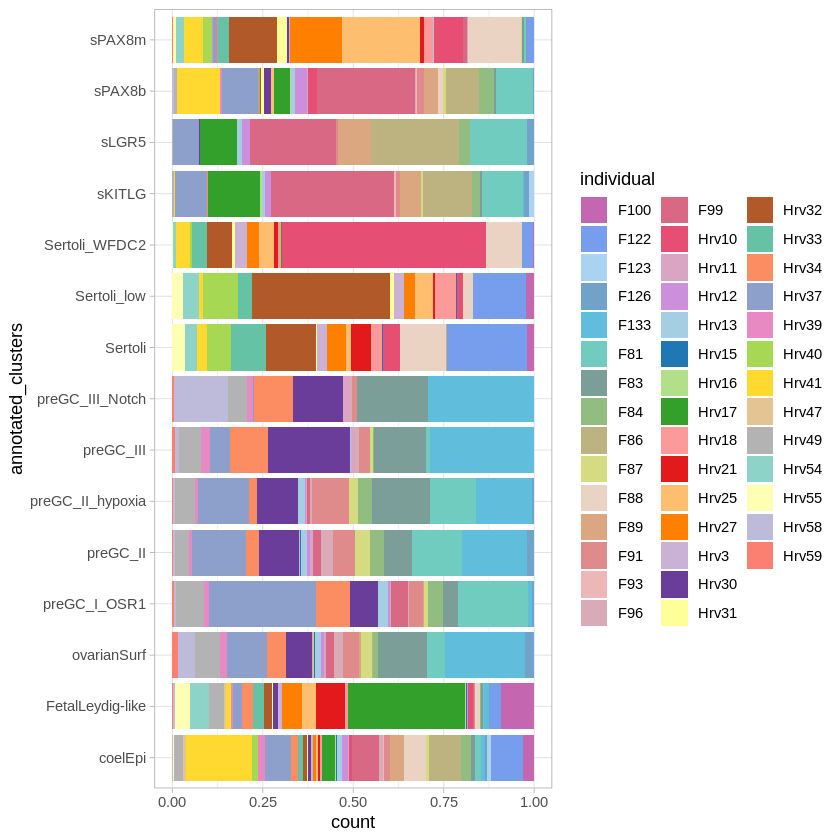

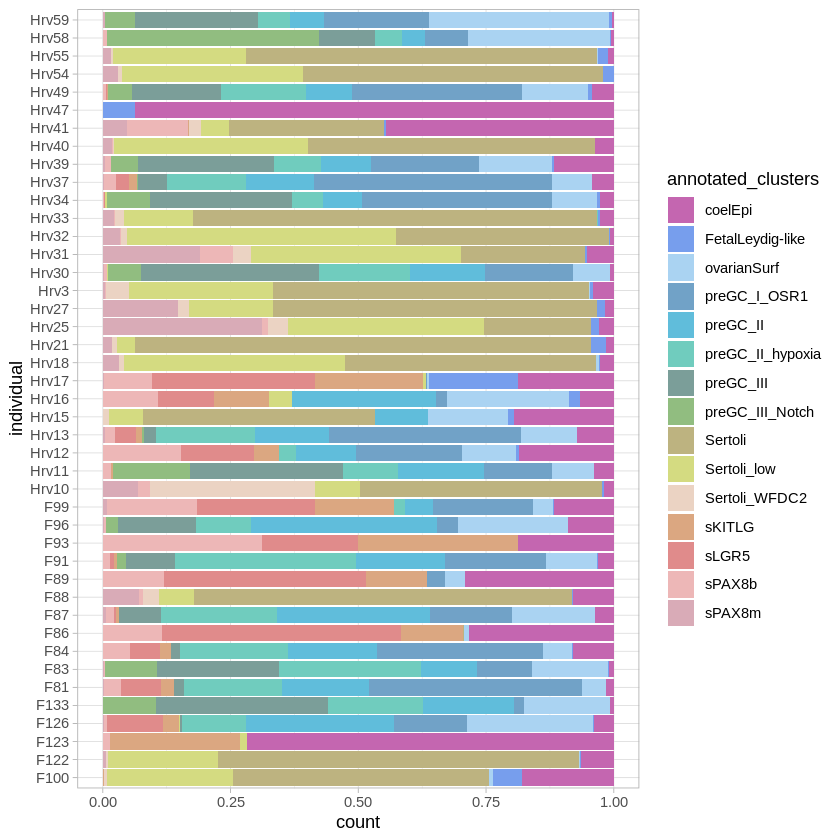

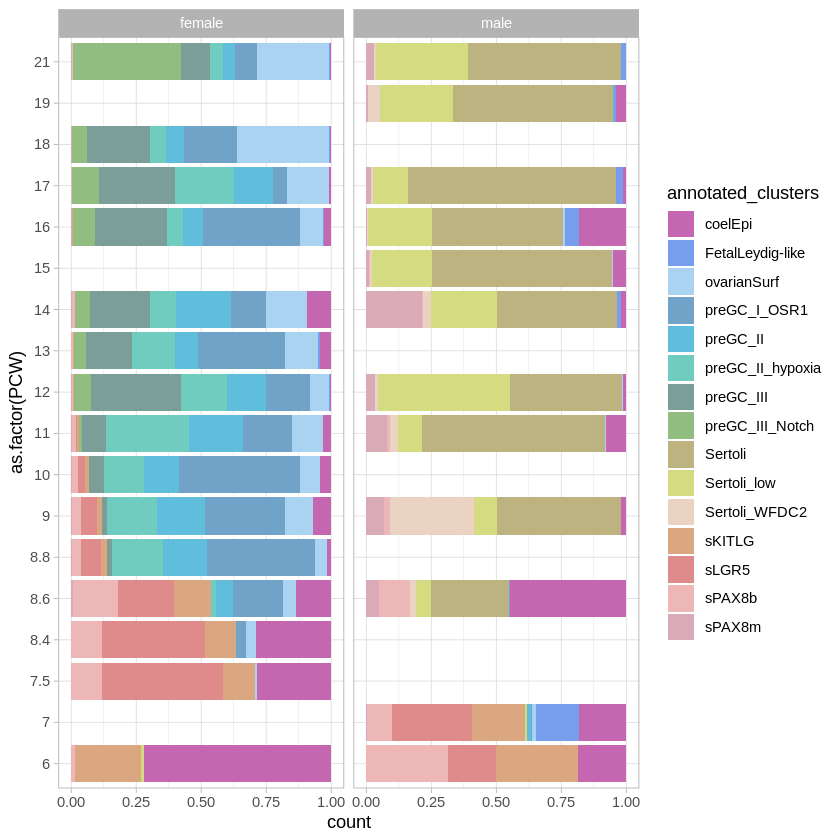

In [45]:
ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = individual , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()
ggplot(anndata@meta.data, aes(x = as.factor(PCW) , fill = annotated_clusters)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +  facet_wrap(~sex) +
    scale_fill_manual(values = colors) + theme_light()

In [46]:
# write.csv(anndata@meta.data, file = paste0('figures-supporting/definitive_annotation.csv'), quote = F, row.names = T)

# Markers

In [47]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-supporting/cleanNocycling_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

[1] 1463   10

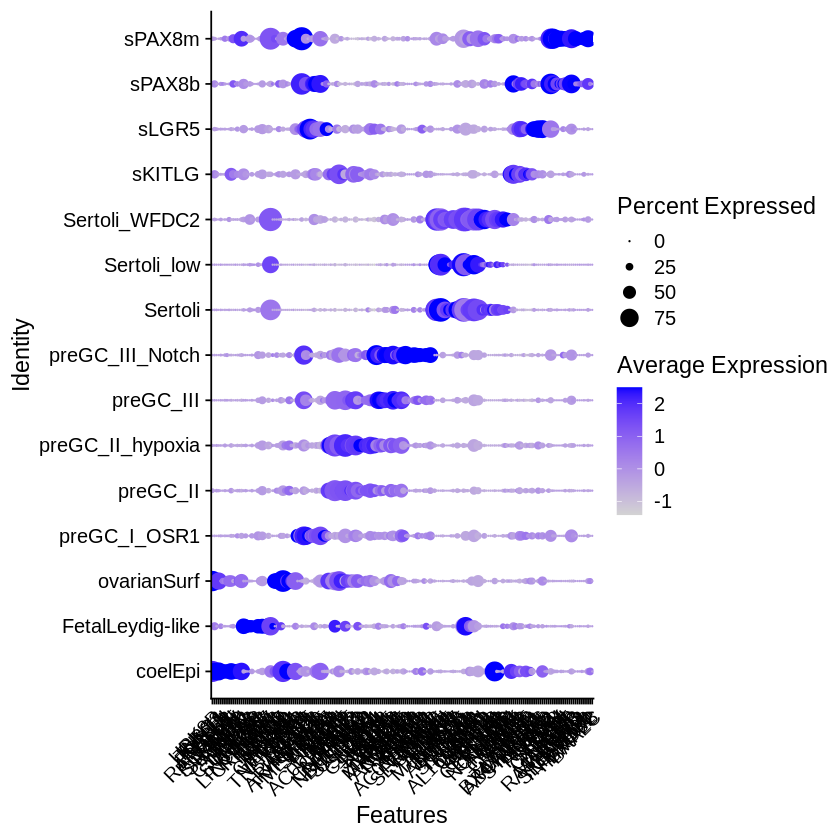

In [48]:
df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

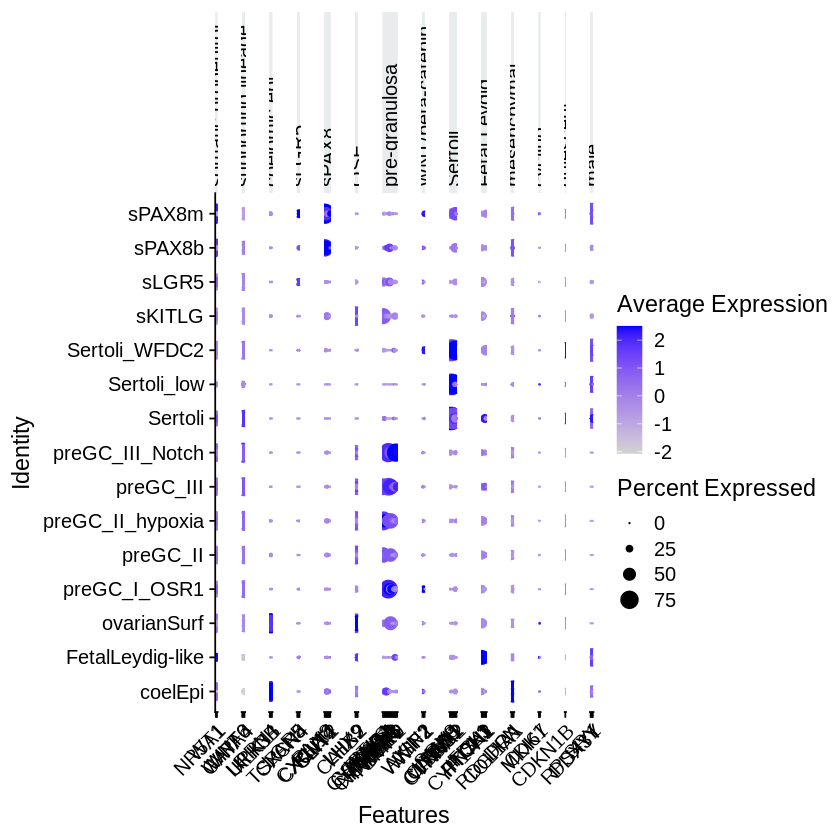

In [49]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

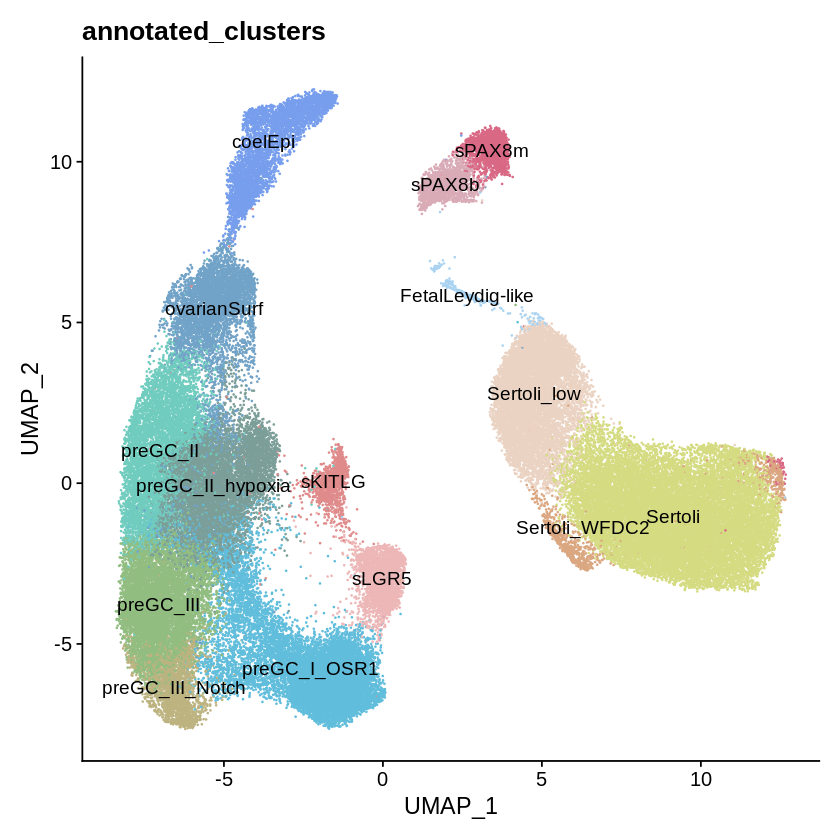

Saving 13.3 x 13.3 in image



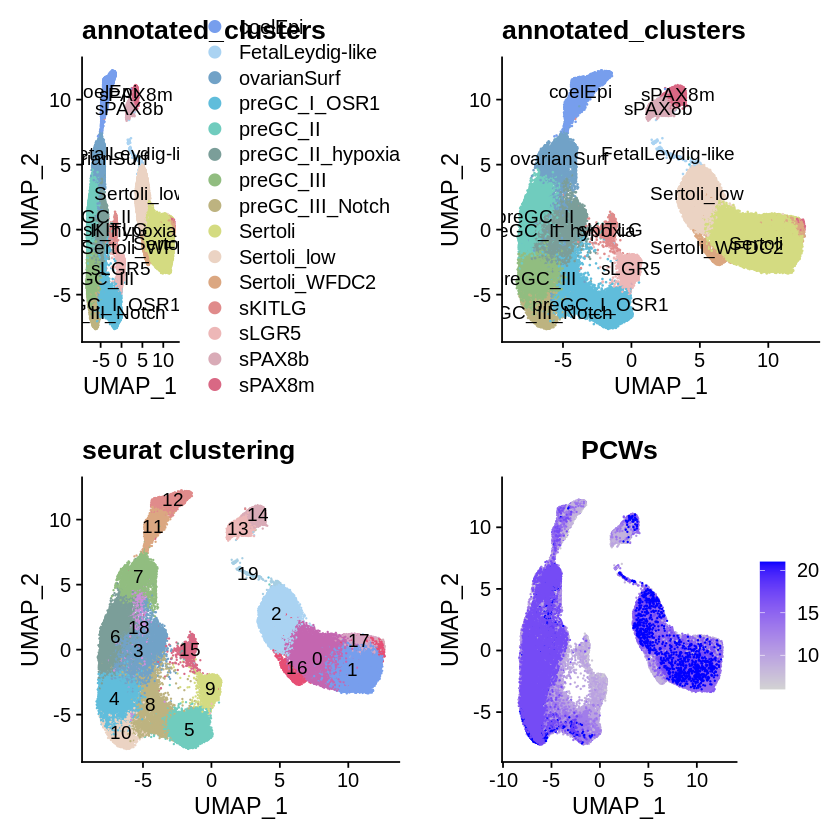

In [50]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()

plot_grid(p1b, p1b+ NoLegend(), p1, p3, ncol = 2)
ggsave(filename = paste0('figures-supporting/cleanNocycling_umap_annotated.pdf'), dpi = 75, scale = 2)

Saving 10.7 x 10.7 in image



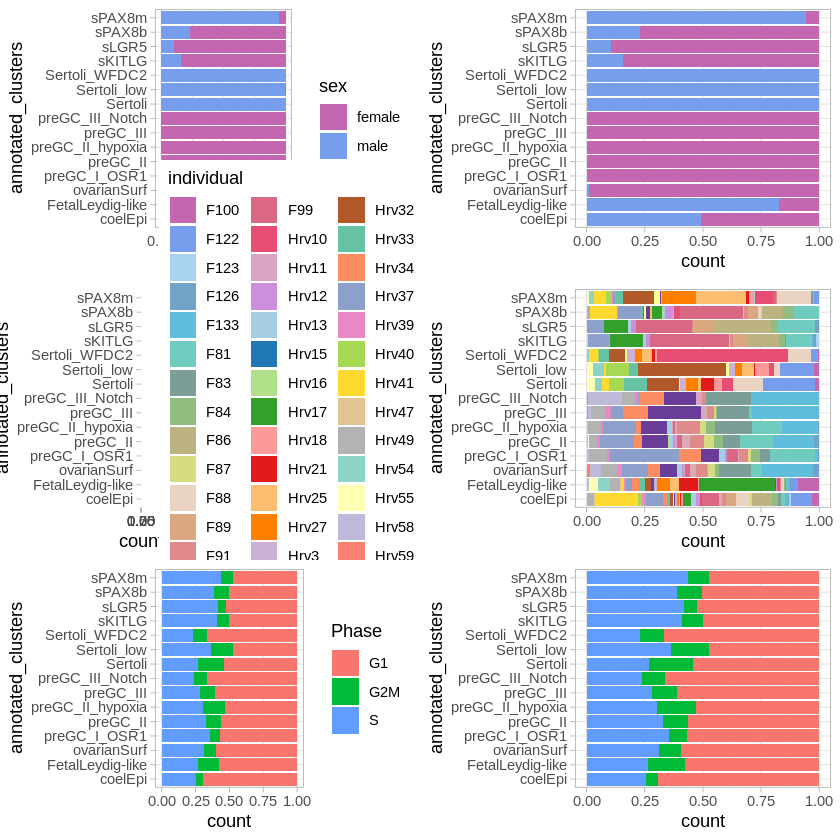

In [51]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()
plot_grid(b1, b1+NoLegend(), b2, b2+NoLegend(),  b3, b3+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-supporting/cleanNocycling_barplots_annotated.pdf'), dpi = 75, scale = 1.6)

Saving 12 x 6.67 in image



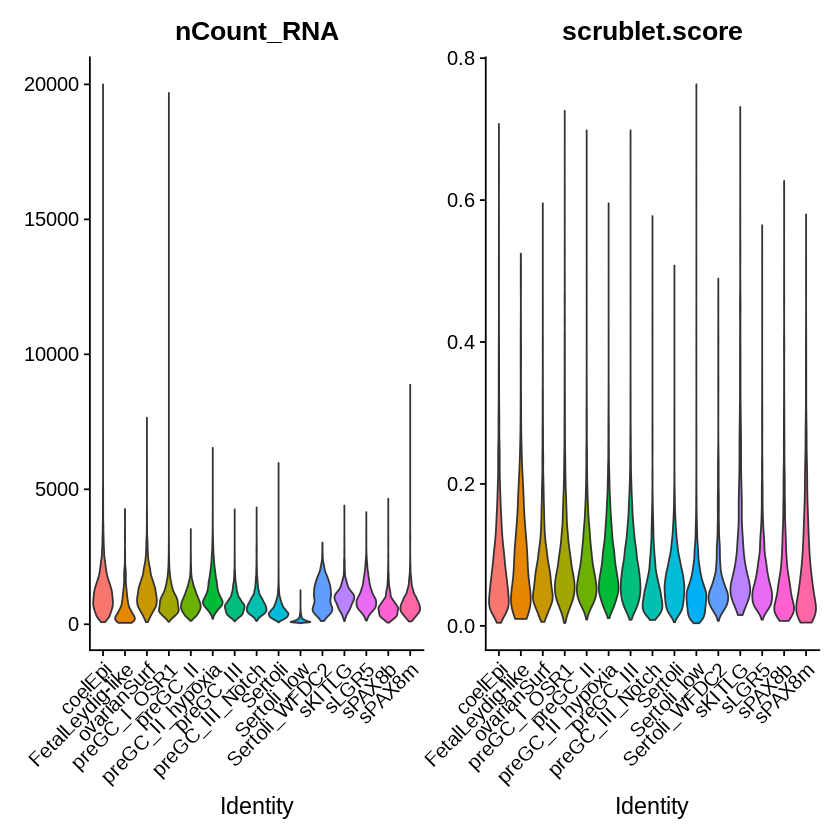

In [52]:
VlnPlot(anndata, c('nCount_RNA', 'scrublet.score'), pt.size = 0)
ggsave(filename = paste0('figures-supporting/cleanNocycling_boxplots_annotated.pdf'), dpi = 75, width = 12)

# TFIDF and Markers

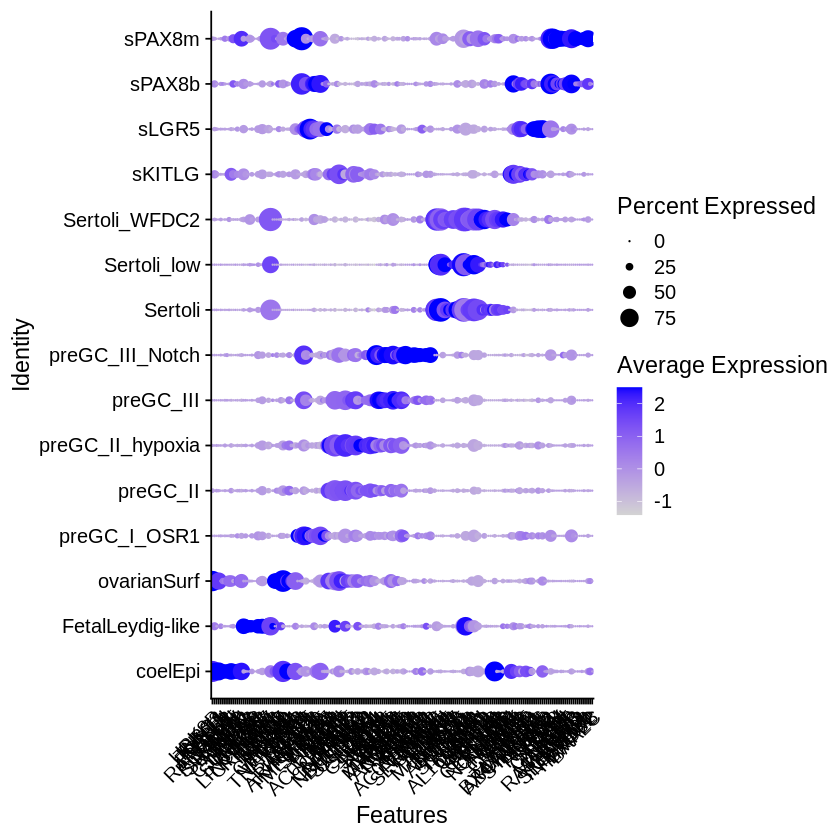

In [53]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
write.csv(df_tfIDF, file = 'figures-supporting/cleanNocycling_cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

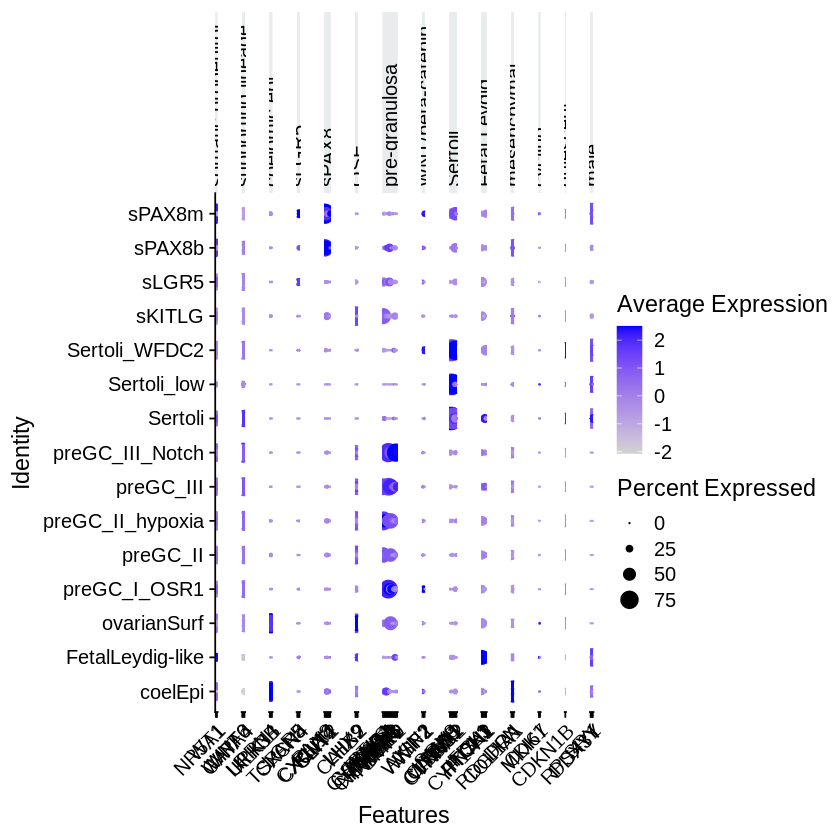

In [54]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

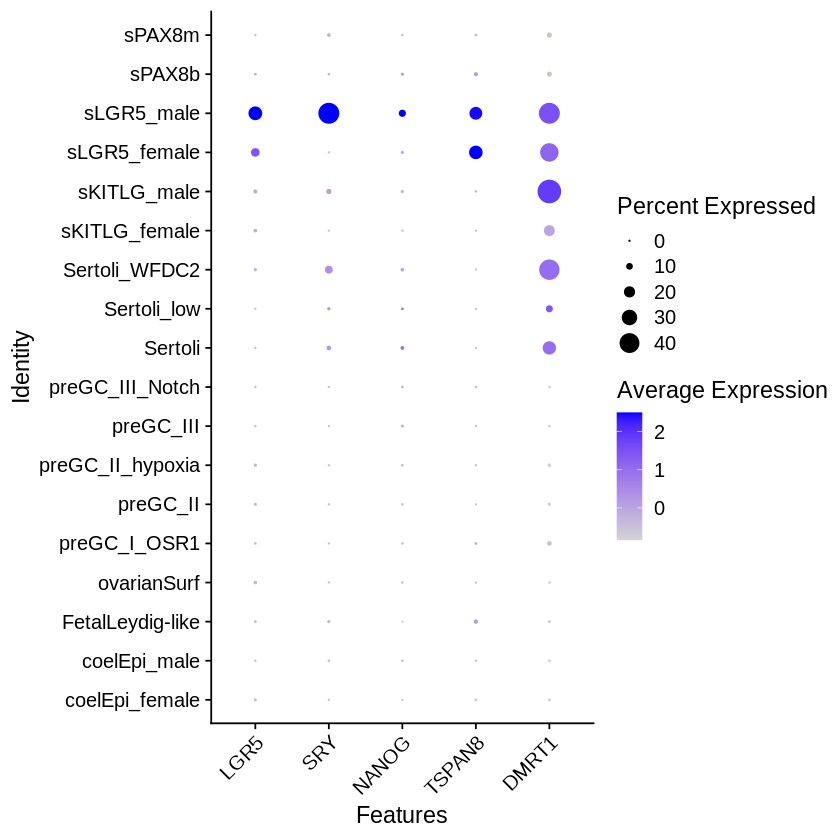

In [66]:
anndataO$annotated_clusters_sex = as.character(anndataO$annotated_clusters)
idx = anndataO$annotated_clusters %in% c(
                 'coelEpi',
                 'sPAX8',
                 'sLGR5',
                  'sKITLG')
anndataO$annotated_clusters_sex[ idx ] = paste0(anndataO$annotated_clusters, '_', anndataO$sex)[idx] 
DotPlot(anndataO, features = c('LGR5', 'TSPAN8', 'DMRT1', 'SRY', 'NANOG'), group.by = 'annotated_clusters_sex') + RotatedAxis()

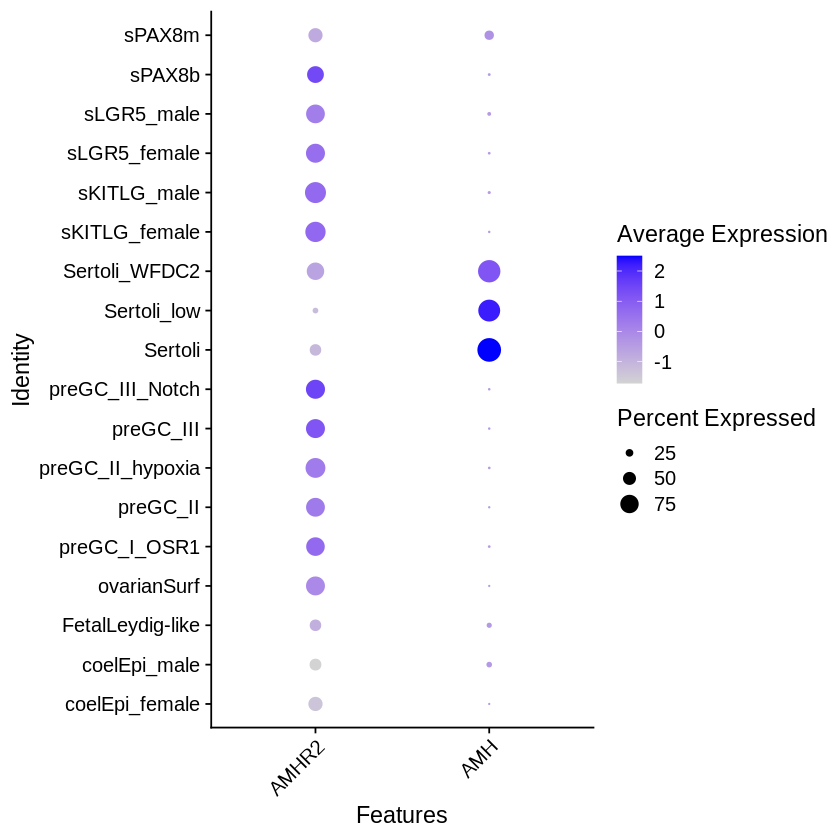

In [56]:
DotPlot(anndataO, features = c('AMHR2', 'AMH'), group.by = 'annotated_clusters_sex') + RotatedAxis()

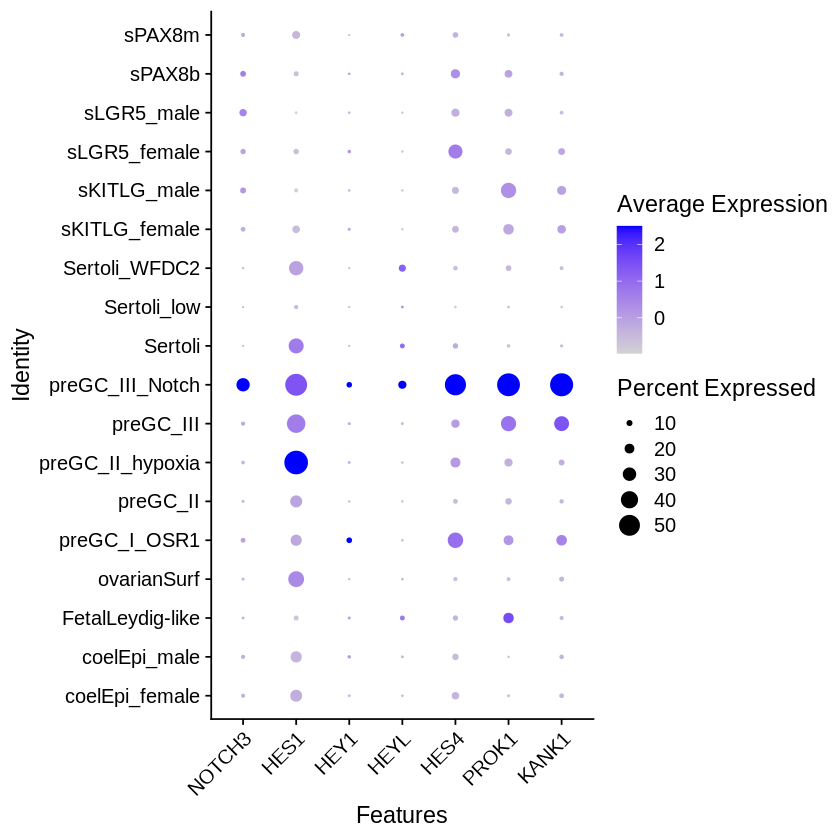

In [57]:
DotPlot(anndataO, features = c('NOTCH3', 'HES1', 'HEY1','HEYL', 'HES4', 'PROK1', 'KANK1'), group.by = 'annotated_clusters_sex') + RotatedAxis()

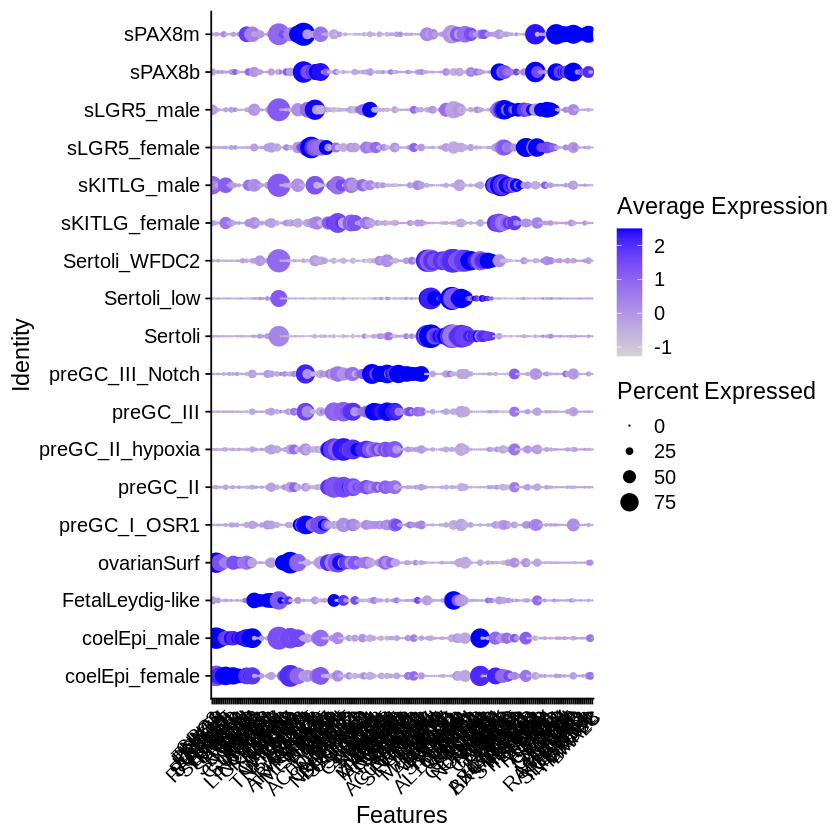

In [58]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = anndataO$annotated_clusters_sex, N = 200)
write.csv(df_tfIDF, file = 'figures-supporting/cleanNocycling_cluster_markersTFIDF_annotatedSex.csv', quote = F, row.names = F)

DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF), group.by = 'annotated_clusters_sex') + RotatedAxis()
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_TFIDF_DEGs_annotatedSex.pdf'), dpi = 75, height = 5, width = 45)

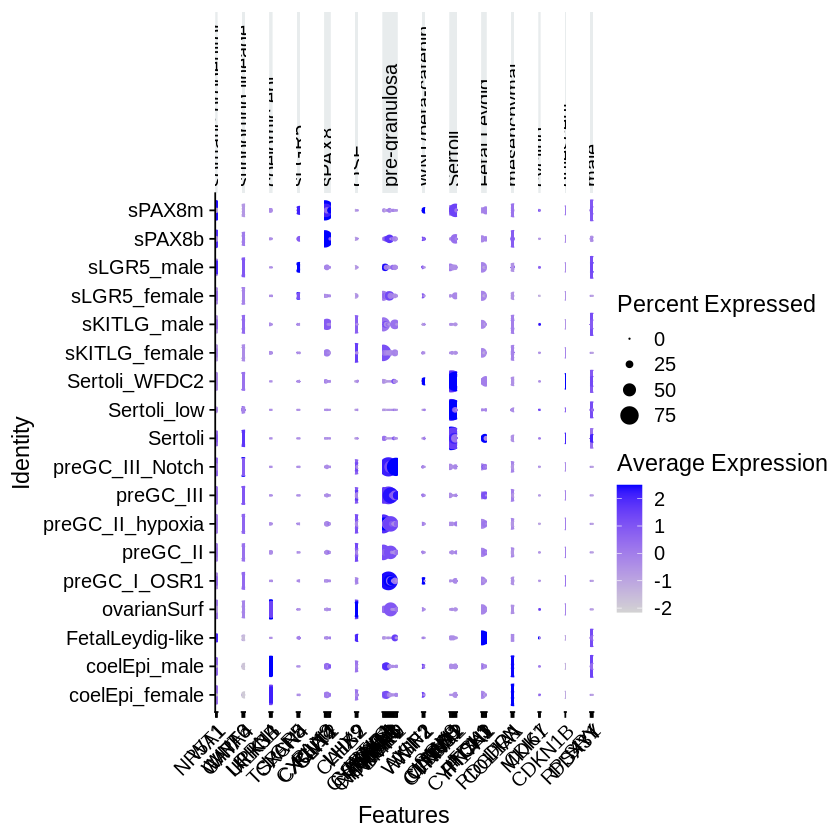

In [59]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters_sex') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-supporting/cleanNocycling_dotplot_markers_annotatedSex.pdf'), dpi = 75, height = 8, width = 25)

# Save

In [60]:
write.csv(anndata@meta.data, file = paste0('figures-supporting/annotated_nocycling.csv'), quote = F, row.names = T)
write.csv(anndata@meta.data, file = '/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/supporting_nocycling.rds')

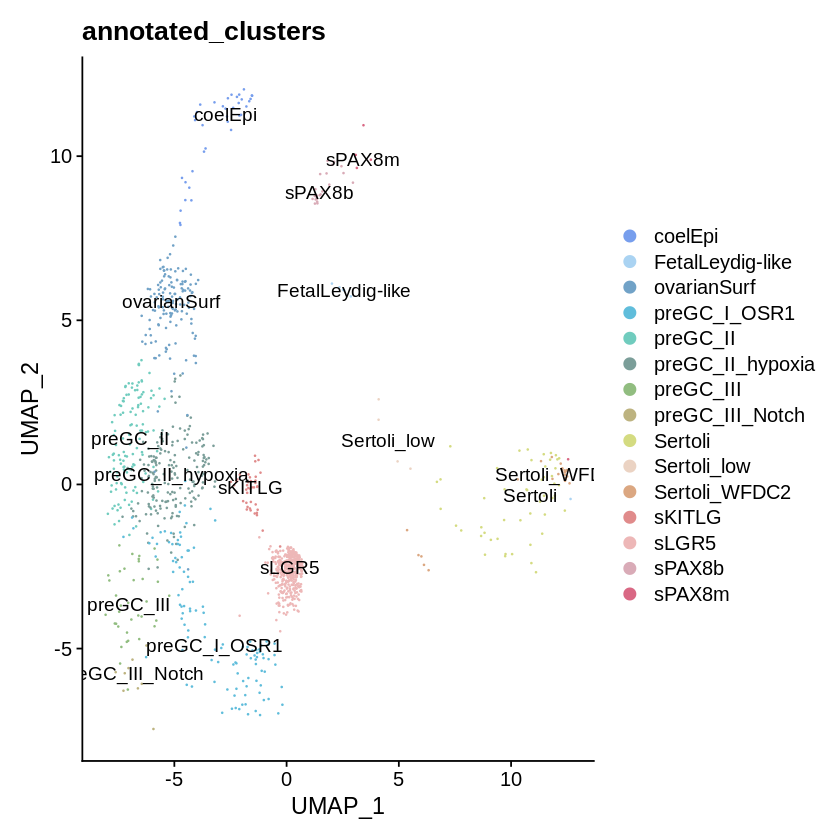

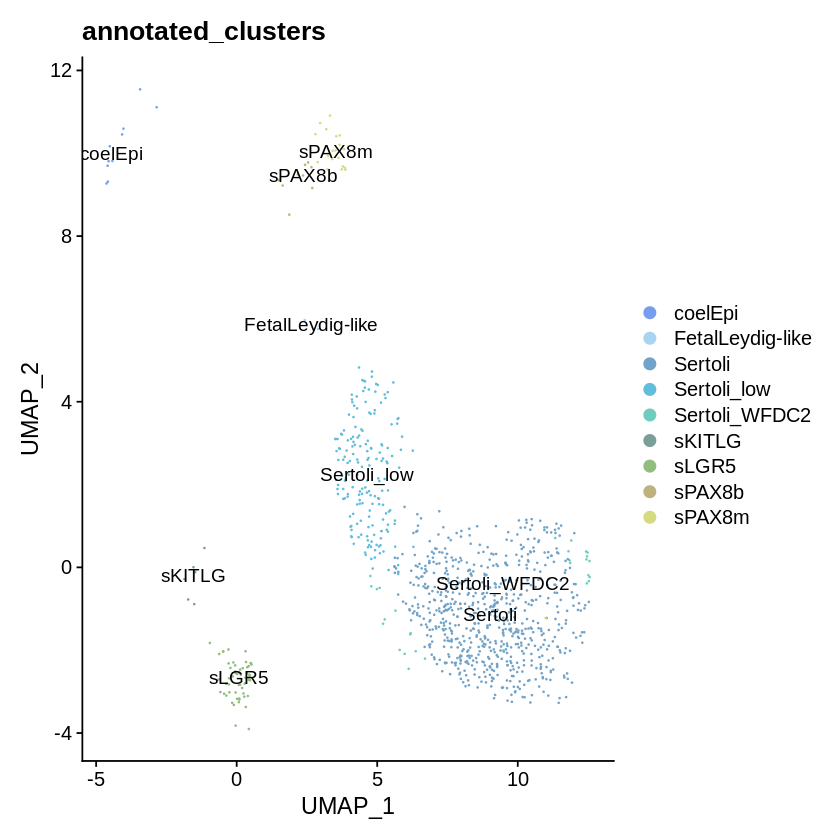

In [61]:
x = subset(anndataO, LGR5 > 0 )
DimPlot(x, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')

y = subset(anndataO, SRY > 1 )
DimPlot(y, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')

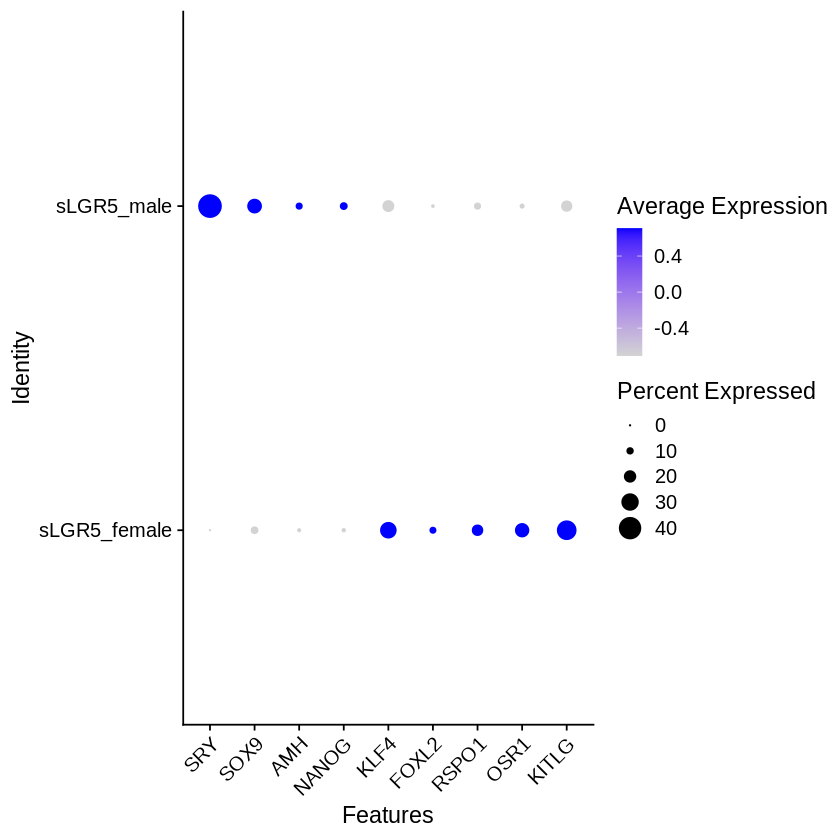

In [62]:
x = subset(anndataO, LGR5 > 0 )
x = subset(x, cells = colnames(x)[ x$annotated_clusters == 'sLGR5' ] )
DotPlot(x, features = c('SRY', 'SOX9', 'AMH', 'NANOG','KLF4','FOXL2', 'RSPO1', 'OSR1', 'KITLG'), group.by = 'annotated_clusters_sex') + RotatedAxis()

In [63]:
x = subset(anndataO, LGR5 > 0 )
gene_counts = tabulate(x@assays$RNA@counts@i+1)
x <- subset(x, features = names(gene_counts)[ gene_counts > 3 ] )

x = subset(x, cells = colnames(x)[ x$annotated_clusters == 'sLGR5' ] )
Idents(x) = x$annotated_clusters_sex
sLGR5_Sexdiff = FindAllMarkers(x, logfc.threshold = 0, min.pct = 0)

Calculating cluster sLGR5_female

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster sLGR5_male



In [64]:
subset(sLGR5_Sexdiff, gene %in% c('CAV1', 'DDIT4') )

p_val        avg_logFC  pct.1 pct.2 p_val_adj    cluster      gene 
DDIT4   4.182688e-12 -0.7706045 0.822 0.945 1.180773e-07 sLGR5_female DDIT4
CAV1    5.297979e-03  0.2535610 0.167 0.041 1.000000e+00 sLGR5_female CAV1 
DDIT4.1 4.182688e-12  0.7706045 0.945 0.822 1.180773e-07 sLGR5_male   DDIT4
CAV1.1  5.297979e-03 -0.2535610 0.041 0.167 1.000000e+00 sLGR5_male   CAV1

In [65]:
sLGR5_Sexdiff[1:20,]

p_val        avg_logFC  pct.1 pct.2 p_val_adj    cluster      gene  
RPS4Y1 4.928611e-88 -2.5563834 0.000 0.973 1.391347e-83 sLGR5_female RPS4Y1
RPS26  8.053230e-37  1.2873339 1.000 0.973 2.273427e-32 sLGR5_female RPS26 
SRY    7.518157e-36 -0.6363180 0.000 0.425 2.122376e-31 sLGR5_female SRY   
KDM5D  7.841552e-29 -0.4265732 0.000 0.342 2.213670e-24 sLGR5_female KDM5D 
DDX3Y  7.841552e-29 -0.4532539 0.000 0.342 2.213670e-24 sLGR5_female DDX3Y 
TTTY15 7.841552e-29 -0.4817407 0.000 0.342 2.213670e-24 sLGR5_female TTTY15
XIST   2.276094e-23  1.0377491 0.716 0.000 6.425414e-19 sLGR5_female XIST  
UTY    3.983118e-23 -0.3333474 0.000 0.274 1.124434e-18 sLGR5_female UTY   
RPL21  4.671827e-23 -0.8776339 0.936 0.973 1.318857e-18 sLGR5_female RPL21 
RPS2   1.287248e-22 -0.7564572 0.994 1.000 3.633902e-18 sLGR5_female RPS2  
EIF1AY 5.327433e-22 -0.3914002 0.000 0.260 1.503934e-17 sLGR5_female EIF1AY
PTOV1  1.171417e-21 -0.8154794 0.737 0.945 3.306912e-17 sLGR5_female PTOV1 
IGFBP2 4.710478e-20 -1.1259816 0.512 0.904 1.329768e-15 sLGR5_female IGFBP2
SLC1A3 2.187621e-19  1.1083744 0.725 0.096 6.175655e-15 sLGR5_female SLC1A3
H1FX   7.380782e-19 -0.9403004 0.520 0.877 2.083595e-14 sLGR5_female H1FX  
LRRN3  1.411083e-18  1.0933069 0.854 0.342 3.983489e-14 sLGR5_female LRRN3 
TAC1   2.134111e-18  1.0158536 0.985 0.603 6.024597e-14 sLGR5_female TAC1  
GSTM1  2.763318e-17  0.6685842 0.585 0.000 7.800846e-13 sLGR5_female GSTM1 
GATM   2.008784e-16  0.6492903 0.980 0.904 5.670798e-12 sLGR5_female GATM  
ODC1   2.828164e-16 -0.8162206 0.845 0.932 7.983906e-12 sLGR5_female ODC1